In [1]:
import os
from astroNN.apogee import allstar, visit_spectra, combined_spectra, gap_delete, apogee_continuum, bitmask_boolean
from astroNN.models import load_folder
from astroNN.apogee.chips import wavelength_solution, chips_split

from astropy.io import fits
from astropy.wcs import WCS
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import traceback
import time

%matplotlib inline
import matplotlib.ticker as ticker

In [2]:
geir_path = "/geir_data/scr/petershi" #should save work here 
sdssv_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/spectra/star" #path for SDSSV spectra
sdssiv_path = "/yngve_data/sdss/apogee/dr17/apogee/spectro/redux/dr17/stars/apo25m"

xmatch_path = "/yngve_data/sdssv/ipl-2/spectro/astra/0.3.0/v6_0_9-1.0/aux_xmatch/ipl-1_dr17_lite_230517_byYS.fits"
model_path = "/geir_data/scr/petershi/models/astroNN_APOGEE_VAC/astroNN_0512_run002"

In [3]:
def getPathList(path_0):

    l = []

    for root, dirs, files in tqdm(os.walk(path_0, topdown=False)):
        for name in files:
            l.append(os.path.join(root, name))
        # for name in dirs:
        #     l.append(os.path.join(root, name))
    return (l, path_0)

In [4]:
def getPath(s, l):
    for elem in l[0]:
        if str(s) in elem:
            return elem

    print("File " + str(s) + " not found in " + str(l[1]))
    return None

In [5]:
def getPathList(path_0):

    l = []

    for root, dirs, files in tqdm(os.walk(path_0, topdown=False)):
        for name in files:
            l.append(os.path.join(root, name))
        # for name in dirs:
        #     l.append(os.path.join(root, name))
    return (l, path_0)

In [6]:
def checkSpec(id):

    try:
        path = getPath(id, sdssiv_files)

        f = fits.open(path)
        # read the raw spectra from apstar
        _spec = np.vstack((f[1].data, f[1].data)) # why the vstack tho...
        _spec_err = np.vstack((f[2].data, f[2].data))
        _spec_mask = np.vstack((f[3].data, f[3].data))

        target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

        _spec = gap_delete(_spec, dr=17)
        _spec_err = gap_delete(_spec_err, dr=17)
        _spec_mask = gap_delete(_spec_mask, dr=17)

        nan_spec = np.isnan(np.sum(_spec))
        nan_err = np.isnan(np.sum(_spec_err))
        nan_mask = np.isnan(np.sum(_spec_mask))

        if nan_spec:
            print("NaN found in spectra")
            print("\n")
            print(_spec)

    except:
        return None


In [7]:
def getSpectrum(star, ind, mask_value):

    spec = star["FLUX"]
    spec_err = star["FLUX_ERR"]
    bitmask = star["BITMASK"]

    target_bit = [0, 1, 2, 3, 4, 5, 6, 7, 12]

    try:
        _normspec, _spec_err = apogee_continuum(spec, spec_err, 
                                                bitmask=bitmask, 
                                                target_bit=target_bit, 
                                                dr=17, mask_value=mask_value)

        return (_normspec, _spec_err)

    except np.linalg.LinAlgError: # for linalgerror
        print("LinAlgError encountered for " + str(ind))
        return None

# Loading Dict of Stars

In [8]:
f = open("/geir_data/scr/petershi/serialized/star_info.pkl", "rb")
#s = open("/geir_data/scr/petershi/serialized/spec_arr.pkl", "rb")

stars = pickle.load(f)
#specs = pickle.load(s)

In [9]:
iv_index = list(stars["SDSS-IV"].keys())
v_index = list(stars["SDSS-V"].keys())

In [10]:
sdssv_files = getPathList(sdssv_path)
sdssiv_files = getPathList(sdssiv_path)

10101it [00:45, 223.90it/s]
1585it [00:27, 58.62it/s] 


In [11]:
print(len(v_index), len(iv_index))

# the different lengths are due to the presence of duplicates matches 
# not of different indices 

21392 21389


In [12]:
xmatch = fits.open(xmatch_path)

cat = xmatch[1].data["cat_id"]
apo = xmatch[1].data["APOGEE_ID"]

In [13]:
excl = [ind for ind in apo if ind not in iv_index]
len(excl)

535

In [14]:
stars["SDSS-IV"][apo[3]]

{'SNR': 507.3629564704115,
 'RA': 34.702978,
 'DEC': -5.813073,
 'FLUX': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'FLUX_ERR': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'BITMASK': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

# Summary Stats of Arrays

In [15]:
ivnan = []
vnan = []

ivsnr = []
vsnr = []

for c, a in tqdm(zip(cat, apo)):

    try:
        cdata = stars["SDSS-V"][c]
    except KeyError as k:
        print(str(c) + " not found")
        cdata = None

    try:
        adata = stars["SDSS-IV"][a]
    except KeyError as k:
        print(str(a) + " not found")
        adata = None
    
    if cdata is not None and adata is not None:

        ctup = getSpectrum(cdata, c, np.nan) # getSpectrum returns tuple of (spectra, spectra err)
        atup = getSpectrum(adata, a, np.nan) # or None if enounters LinAlgError


        if ctup is not None and atup is not None:
            
            cspec = ctup[0][0]
            aspec = atup[0][0]
            

            vnan.append(sum(np.isnan(cspec)))
            ivnan.append(sum(np.isnan(aspec)))

            vsnr.append(cdata["SNR"])
            ivsnr.append(adata["SNR"])



0it [00:00, ?it/s]

329915927 not found
2M02222833-0609582 not found


15it [00:02, 10.45it/s]

736959791 not found
2M02202243-0619106 not found
736959791 not found
2M02202243-0619106 not found


30it [00:02, 16.30it/s]/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-packages/astroNN/apogee/chips.py:252: RuntimeWarning: invalid value encountered in divide
/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-packages/astroNN/apogee/chips.py:253: RuntimeWarning: invalid value encountered in divide
34it [00:03, 19.39it/s]


LinAlgError encountered for 2M20304144+3945153
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20301336+3942050

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


56it [00:03, 43.57it/s]

LinAlgError encountered for 4215379770
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20265541+4009511
4215381789 not found
2M20273918+4013302 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20255278+4016336

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4215425861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20321777+4014081

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


80it [00:03, 63.00it/s]

LinAlgError encountered for 2M20340288+4110409
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20340288+4110409

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


106it [00:04, 74.35it/s]

LinAlgError encountered for 4215545692
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20334742+4124443

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


123it [00:04, 69.30it/s]

4215717675 not found
2M20213607+4047561 not found


168it [00:04, 64.55it/s]

LinAlgError encountered for 4256127873
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



201it [00:05, 89.96it/s]

4268552892 not found
2M18492764+5750238 not found


242it [00:05, 91.91it/s]

4269217945 not found
2M18294651+6215309 not found
LinAlgError encountered for 4269219195

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18341143+6233261

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


270it [00:06, 71.11it/s]

LinAlgError encountered for 4269338769
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



497it [00:09, 58.66it/s] 

LinAlgError encountered for 2M00591505+8417589

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M00591505+8417589

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


740it [00:15, 35.66it/s]


Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4326414350
LinAlgError encountered for 2M01284102+8612222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4326414350

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M01284102+8612222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


832it [00:16, 92.43it/s]

4342021178 not found
2M05122780+4951163 not found


863it [00:17, 91.57it/s]

4342080964 not found
2M05141486+4854311 not found


904it [00:17, 99.86it/s]

4342145794 not found
2M05194409+4955218 not found


926it [00:17, 100.34it/s]

4342197943 not found
2M05214411+4848215 not found


990it [00:18, 126.64it/s]

LinAlgError encountered for 4345886810
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16521884+4626191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4345886810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16521884+4626191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4345889508

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16553850+4723287

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1065it [00:18, 135.66it/s]

4345904409 not found
2M16474783+4642497 not found
4345905435 not found
2M16483241+4713133 not found


1095it [00:18, 135.29it/s]

LinAlgError encountered for 2M16544403+4810412
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



1123it [00:19, 133.12it/s]

LinAlgError encountered for 4345979501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16484982+4843263

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1355it [00:21, 106.19it/s]

LinAlgError encountered for 2M16133238+4634167
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 4346210701

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16153915+4712530

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1399it [00:21, 102.94it/s]

LinAlgError encountered for 4346215961

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16082164+4707249

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1474it [00:22, 98.67it/s] 

LinAlgError encountered for 2M16083162+4828486
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



1522it [00:23, 113.26it/s]

LinAlgError encountered for 4346249860
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16082716+4651531

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346249860

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16082716+4651531

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1603it [00:23, 106.32it/s]

LinAlgError encountered for 4346270178
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16011625+4712002

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270178

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16011625+4712002

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270266

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16003597+4716201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270266

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16003597+4716201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1643it [00:24, 124.03it/s]

4346373677 not found
2M16191441+5230475 not found


1704it [00:24, 144.07it/s]

LinAlgError encountered for 2M16153414+5029120
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16153414+5029120

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16153414+5029120

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1753it [00:24, 151.25it/s]

LinAlgError encountered for 4346386478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16135972+5118410

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346386478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16135972+5118410

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1942it [00:26, 134.10it/s]

LinAlgError encountered for 4347186336

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17255324+7522017

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2025it [00:27, 148.93it/s]

4347264081 not found
2M17100026+7252332 not found


2075it [00:27, 154.72it/s]

LinAlgError encountered for 4347372699
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16344390+6351431

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2120it [00:27, 131.96it/s]

4347404119 not found
2M16333583+6744255 not found
LinAlgError encountered for 4347412595

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16291003+6522058

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2192it [00:28, 139.77it/s]

LinAlgError encountered for 4347426623

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16205296+6642507

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347426623

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16205296+6642507

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16265817+6257504

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16274311+6305101

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2241it [00:28, 149.26it/s]

LinAlgError encountered for 4347445168
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16264189+6417240

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447192

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16211375+6409440

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447192

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16211375+6409440

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447634

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16234067+6255046

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447808

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16225977+63

2271it [00:28, 143.87it/s]

LinAlgError encountered for 4347451105

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
4347463835 not found
2M16180701+6256577 not found
LinAlgError encountered for 4347475069

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16233794+6447231

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2357it [00:29, 136.46it/s]

4347487002 not found
2M16171808+6604252 not found
LinAlgError encountered for 4347489794

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16143536+6631360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347489794

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16143536+6631360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2422it [00:29, 143.98it/s]

LinAlgError encountered for 4347735199
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17384724+7626530

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4347736469 not found
2M17320971+7556062 not found
4347737073 not found
2M17352146+7623510 not found


2557it [00:32, 63.22it/s] 

4348127214 not found
2M15094399+8733439 not found


2659it [00:33, 81.50it/s]

LinAlgError encountered for 4349128877
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15064993+5702285

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2712it [00:34, 69.03it/s]

LinAlgError encountered for 2M15310801+3924322
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



2769it [00:35, 78.39it/s]

LinAlgError encountered for 4350478853
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15280976+3828426

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4350478853

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15280976+3828426

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2786it [00:35, 75.96it/s]

LinAlgError encountered for 2M15222446+3926505

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2814it [00:35, 87.33it/s]

LinAlgError encountered for 4350484722
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15233073+3835593

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15223378+3807373

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15223378+3807373

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15214812+3820462

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15214812+3820462

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2839it [00:36, 68.42it/s]

LinAlgError encountered for 2M14481180+4138284
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



2920it [00:37, 60.29it/s]

LinAlgError encountered for 2M14453246+4155156
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3022it [00:38, 107.18it/s]

LinAlgError encountered for 2M14180845+5340109
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3057it [00:39, 110.57it/s]

LinAlgError encountered for 2M14134180+5314443

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3114it [00:39, 124.01it/s]

LinAlgError encountered for 2M14101638+5356296
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3160it [00:39, 139.66it/s]

LinAlgError encountered for 4351028263
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14115659+5541252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3271it [00:40, 124.86it/s]

LinAlgError encountered for 4351081432
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14190194+5213545

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351081432

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14190194+5213545

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14155364+5242561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14155364+5242561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3319it [00:41, 105.87it/s]

LinAlgError encountered for 4351098948
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14105715+5311566

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3352it [00:41, 101.30it/s]

LinAlgError encountered for 2M14055319+5227233
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3444it [00:42, 97.98it/s] 

LinAlgError encountered for 4351113398
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M13553460+5154447

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3742it [00:45, 69.77it/s] 

LinAlgError encountered for 2M13094301+5630275
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3840it [00:47, 99.04it/s]

LinAlgError encountered for 4351458320
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 4351458320

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351458335

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351458335

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351460849

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M12515570+5638586

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3870it [00:47, 86.79it/s]

LinAlgError encountered for 4351659571

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M13330626+5010328

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3889it [00:47, 87.82it/s]

LinAlgError encountered for 2M13285385+5047480
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



4383it [00:52, 80.11it/s] 

LinAlgError encountered for 4360719354
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M10370576+4324353

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4360719354

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10370576+4324353

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4443it [00:53, 91.45it/s]

4360753174 not found
2M10313479+4315530 not found


4710it [00:55, 88.08it/s] 

LinAlgError encountered for 4368363445
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21343149-0056169

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4368363445

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21343149-0056169

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4368365584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21352740-0116452

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4728it [00:55, 87.56it/s]

4368374685 not found
2M21362650-0030020 not found
4368374685 not found
2M21362650-0030020 not found


4784it [00:56, 106.81it/s]

LinAlgError encountered for 4368638641

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22132836-0133225

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4807it [00:56, 104.19it/s]

LinAlgError encountered for 4368644874

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22130723-0047492

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4844it [00:56, 115.74it/s]

LinAlgError encountered for 4370294960
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



4868it [00:57, 105.20it/s]

LinAlgError encountered for 4371144020
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M23383208-0037274

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4940it [00:57, 91.78it/s] 

LinAlgError encountered for 2M00083061-0000000
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



4968it [00:58, 85.52it/s]

4374647409 not found
2M00390960-0026314 not found


4999it [00:58, 120.51it/s]

4375029185 not found
2M01130702-0125305 not found
4375029926 not found
2M01130209-0107486 not found
4375029993 not found
2M01134189-0114454 not found
4375030221 not found
2M01133349-0102561 not found
4375030628 not found
2M01141741-0053020 not found
4375032898 not found
2M01125746-0045188 not found
4375033398 not found
2M01143109-0050090 not found


5083it [00:59, 138.77it/s]

4375786510 not found
2M02194466-0617592 not found
4375786807 not found
2M02182932-0558574 not found
4375786824 not found
2M02182102-0556261 not found
4375787249 not found
2M02201618-0554030 not found
4375787288 not found
2M02210199-0628046 not found
4375787364 not found
2M02212236-0627297 not found
4375787498 not found
2M02212335-0620577 not found
4375787519 not found
2M02211201-0614340 not found
4375787744 not found
2M02220353-0613343 not found
4375787989 not found
2M02210851-0603397 not found
4375788094 not found
2M02210355-0557319 not found
4375790650 not found
2M02225115-0629425 not found
4375790701 not found
2M02230578-0621029 not found
4375790800 not found
2M02225480-0619303 not found
4375790840 not found
2M02230469-0612104 not found


5724it [01:05, 80.90it/s] 

LinAlgError encountered for 4377409774
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21340159+0019261

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5817it [01:06, 97.18it/s] 

LinAlgError encountered for 2M22215687+0114044
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 4381177933

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22235262+0114296

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5847it [01:07, 91.20it/s]

LinAlgError encountered for 2M23412036+0029008
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M23485038+0007057

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5915it [01:07, 85.78it/s]

LinAlgError encountered for 4399109721
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M00052400+0059515

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6089it [01:10, 103.15it/s]

LinAlgError encountered for 2M01265856+0135153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6515it [01:14, 113.48it/s]

LinAlgError encountered for 4401948182
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M02533880+0017183

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4401948182

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02533880+0017183

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6611it [01:14, 138.21it/s]

4417189187 not found
2M05284036-0244012 not found
4417191886 not found
2M05245296-0238437 not found
4417194234 not found
2M05263647-0233423 not found
LinAlgError encountered for 2M05243300-0205395

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4417203126 not found
2M05292958-0215399 not found
4417205847 not found
2M05280099-0201138 not found
4417206768 not found
2M05281346-0156491 not found
4417208302 not found
2M05301868-0201575 not found
4417208818 not found
2M05312120-0205569 not found
4417209649 not found
2M05312070-0158522 not found


6663it [01:15, 149.86it/s]

4417258647 not found
2M05281045-0146183 not found
4417259063 not found
2M05282747-0138471 not found
4417261346 not found
2M05294888-0139281 not found
4417301681 not found
2M05320849-0610134 not found
4417628795 not found
2M05313136-0149332 not found
LinAlgError encountered for 2M07364229-1303499

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6738it [01:16, 99.52it/s] 

LinAlgError encountered for 2M06450343-0034140
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



6750it [01:16, 101.52it/s]

LinAlgError encountered for 4477186294
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

4477991651 not found
2M06572358-0525093 not found


6770it [01:16, 82.61it/s] 

LinAlgError encountered for 4491880043
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08305997-0035215

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6820it [01:17, 89.05it/s]

4492117624 not found
2M08573169-0039281 not found


7098it [01:20, 103.94it/s]

LinAlgError encountered for 2M05280968+3516540
4514124005 not found
2M05254477+3538499 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


7166it [01:21, 103.58it/s]

LinAlgError encountered for 2M06422978+0053582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4524680345 not found
2M06314796+0419381 not found
4524686209 not found
2M06340245+0351043 not found
4524687486 not found
2M06322566+0402072 not found


7192it [01:21, 115.48it/s]

4524710007 not found
2M06315156+0454175 not found
LinAlgError encountered for 4524715218

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M06323155+0427320

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4524717908

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M06323495+0444392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4524726852 not found
2M06321821+0503216 not found


7238it [01:22, 100.55it/s]

LinAlgError encountered for 4536791628
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

4536796979 not found
2M06325506+1624376 not found
LinAlgError encountered for 4536812776

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


7332it [01:23, 77.89it/s] 

LinAlgError encountered for 4542150205

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M07352669+1609005

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


7450it [01:24, 68.29it/s]

LinAlgError encountered for 4542224332
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07371304+1831260

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


7464it [01:25, 67.96it/s]

LinAlgError encountered for 4542238469

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


7730it [01:28, 94.73it/s]

LinAlgError encountered for 4543110318
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



8115it [01:33, 95.61it/s]

LinAlgError encountered for 2M08411685+0227102
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08411685+0227102

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


8229it [01:34, 87.46it/s]

4545115147 not found
2M08442090+0436100 not found


8442it [01:37, 96.14it/s]

4545192015 not found
2M08563812+0220501 not found


8494it [01:37, 100.47it/s]

4545208892 not found
2M08515624+0301274 not found


8578it [01:38, 116.29it/s]

LinAlgError encountered for 4545237478
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08535559+0338561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545237478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08535559+0338561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


8700it [01:39, 120.78it/s]

LinAlgError encountered for 4545260888
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08571630+0459563

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545260888

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08571630+0459563

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545261928

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545261928

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


9002it [01:42, 114.75it/s]

LinAlgError encountered for 4546458700
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08094605+2156268

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4546463869 not found
2M08082571+2252246 not found


9175it [01:43, 121.66it/s]

4546853317 not found
2M08364151+1909297 not found


9300it [01:44, 94.49it/s] 

LinAlgError encountered for 4551561548

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M07421707+3028422

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


9828it [01:51, 105.47it/s]

4554288852 not found
2M07531302+2605200 not found


10198it [01:56, 69.52it/s] 

LinAlgError encountered for 4554431603
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 4554431603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554431603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


10307it [01:57, 99.65it/s] 

4554461275 not found
2M08084653+2457440 not found


10380it [01:57, 118.98it/s]

LinAlgError encountered for 4554474029

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08175518+2427097

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554474029

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08175518+2427097

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554475880

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08191980+2219262

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


10936it [02:03, 108.32it/s]

4554826346 not found
2M08241696+2922091 not found


11030it [02:03, 129.09it/s]

LinAlgError encountered for 4555021969
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08274623+2713491

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11057it [02:04, 128.50it/s]

LinAlgError encountered for 2M08292816+2817155
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



11173it [02:05, 94.11it/s] 

LinAlgError encountered for 2M08041010+3308332
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



11295it [02:06, 98.50it/s] 

LinAlgError encountered for 4555261594
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07523361+3730511

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11335it [02:07, 90.84it/s]

4555274392 not found
2M08063253+3505044 not found


11414it [02:07, 88.67it/s]

LinAlgError encountered for 4555305796

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08095670+3343233

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11459it [02:08, 99.20it/s]

4555339658 not found
2M08082742+3452508 not found


11549it [02:09, 109.54it/s]

LinAlgError encountered for 2M08172381+3454091
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

4555361360 not found
2M08155504+3550165 not found


11654it [02:10, 150.97it/s]

4555488746 not found
2M08155284+3602277 not found
4555488931 not found
2M08154292+3612051 not found
4555488990 not found
2M08164326+3602066 not found
4555489293 not found
2M08172436+3605029 not found
4555489352 not found
2M08174938+3601273 not found
4555489355 not found
2M08174947+3602546 not found
4555489415 not found
2M08154414+3619563 not found
4555489415 not found
2M08154414+3619563 not found
4555489475 not found
2M08164282+3609548 not found
4555489610 not found
2M08161389+3619396 not found
4555489610 not found
2M08161389+3619396 not found
4555489789 not found
2M08174570+3606106 not found
4555489893 not found
2M08171269+3620090 not found
4555489942 not found
2M08174886+3614021 not found
4555499584 not found
2M08154093+3710575 not found
4555500199 not found
2M08174444+3708109 not found


11699it [02:10, 186.40it/s]

4555501967 not found
2M08170744+3720244 not found
4555502216 not found
2M08175354+3723131 not found
4555502222 not found
2M08175981+3723252 not found
4555502962 not found
2M08182403+3551566 not found
4555502968 not found
2M08183431+3550396 not found
4555503539 not found
2M08182594+3605408 not found
4555503610 not found
2M08185075+3604527 not found
4555503644 not found
2M08180403+3609341 not found
4555503717 not found
2M08184255+3607528 not found
4555503886 not found
2M08201748+3553117 not found
4555503920 not found
2M08202649+3555401 not found
4555504013 not found
2M08200619+3600208 not found
4555504917 not found
2M08210672+3558345 not found
4555504922 not found
2M08210572+3601150 not found
4555505543 not found
2M08185017+3626452 not found
4555505809 not found
2M08195154+3616320 not found
4555505829 not found
2M08201649+3614037 not found
4555512135 not found
2M08180305+3656117 not found
4555515261 not found
2M08193494+3732465 not found


11779it [02:10, 129.08it/s]

LinAlgError encountered for 4555530459
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08173692+3830533

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11914it [02:12, 101.93it/s]

LinAlgError encountered for 4570390839
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09134468-0136459

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11937it [02:12, 102.45it/s]

LinAlgError encountered for 4570395051
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09103989-0058003

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4570399108

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09103626-0001068

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11959it [02:12, 101.60it/s]

LinAlgError encountered for 4570400737
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09122842-0059032

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11992it [02:13, 101.80it/s]

LinAlgError encountered for 4570482063
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09172925-0134422

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12081it [02:14, 80.34it/s] 

LinAlgError encountered for 4587778949
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M13165074-1345252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12535it [02:20, 122.03it/s]

LinAlgError encountered for 4592542548

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09142689+0053085

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09141161+0113464

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12605it [02:20, 136.42it/s]

LinAlgError encountered for 4592571752

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592571752

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592571752

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


12663it [02:21, 138.47it/s]

LinAlgError encountered for 4592625327
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09231122+0056056

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592634562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09200077+0156154

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592634562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09200077+0156154

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4592636395 not found
2M09222963+0159376 not found


12809it [02:22, 128.83it/s]

LinAlgError encountered for 2M09282119+0140466

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4592663936 not found
2M09291446+0150313 not found
LinAlgError encountered for 4592664090

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09295208+0152560

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13005it [02:24, 113.05it/s]

LinAlgError encountered for 4592713988
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09240139+0506566

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13049it [02:24, 95.81it/s] 

LinAlgError encountered for 4592920995
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09333257+0116248

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592922202

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09364127+0053199

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13233it [02:26, 131.61it/s]

LinAlgError encountered for 2M09564888+0205202

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13427it [02:28, 70.24it/s] 

LinAlgError encountered for 2M11184071+1027296
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



13680it [02:31, 76.69it/s]

LinAlgError encountered for 4597773441
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M11161084+4014456

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4597773889 not found
2M11160844+4031475 not found


13800it [02:33, 94.19it/s]

4599337339 not found
2M12120056+1930297 not found


14206it [02:38, 99.00it/s]

LinAlgError encountered for 4600458837
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



14288it [02:39, 110.72it/s]

4600797577 not found
2M14360851+0437227 not found


14338it [02:39, 119.11it/s]

4600806784 not found
2M14374255+0355009 not found


15167it [02:49, 75.48it/s] 

LinAlgError encountered for 2M14211810+3710010
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



15189it [02:49, 89.63it/s]

4603912535 not found
2M14472870+3447489 not found


15240it [02:49, 113.96it/s]

4834724428 not found
2M17220012-1418508 not found
4834747301 not found
2M17242503-1428178 not found
4834751251 not found
2M17240891-1418376 not found
4834791559 not found
2M17224579-1359285 not found
4835170964 not found
2M17260031-1431255 not found
4835179873 not found
2M17253213-1427208 not found
4835220069 not found
2M17273907-1419530 not found
4835222233 not found
2M17245065-1414304 not found
4835230887 not found
2M17261150-1416092 not found
4835238557 not found
2M17251787-1401217 not found
4835260205 not found
2M17275804-1416101 not found
4835260528 not found
2M17275524-1413030 not found


15273it [02:50, 82.91it/s] 

LinAlgError encountered for 2M16301118-0109073
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



15299it [02:50, 74.89it/s]

LinAlgError encountered for 2M16340687-0104536
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



15406it [02:51, 156.74it/s]

4864932865 not found
2M17223941-1341019 not found
4864948121 not found
2M17231574-1344082 not found
4864995528 not found
2M17235826-1323409 not found
4865180222 not found
2M17245211-1337018 not found
4865186001 not found
2M17252769-1340106 not found
4865200385 not found
2M17272460-1352038 not found
4878998509 not found
2M17443987-0057548 not found
4878998923 not found
2M17444685-0055295 not found
4879067195 not found
2M17443220-0044511 not found
4879069608 not found
2M17450265-0046483 not found
4879073937 not found
2M17444685-0032489 not found
4879077746 not found
2M17452823-0029171 not found
4879091873 not found
2M17442930-0022367 not found
4879092204 not found
2M17444533-0021255 not found
4879100754 not found
2M17445498-0007548 not found
4879754727 not found
2M17454391-0043489 not found
4879760372 not found
2M17462079-0038584 not found
4879762276 not found
2M17462149-0028507 not found
4879762497 not found
2M17462909-0027500 not found
4879762561 not found
2M17463984-0039274 not found


15619it [02:54, 66.17it/s] 

5171020305 not found
2M15323585+0727428 not found
LinAlgError encountered for 5172775089

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16330711+0005039

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15667it [02:55, 93.66it/s]

LinAlgError encountered for 2M16345545+0046492
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

5177322272 not found
2M17462121+0000341 not found
5177325683 not found
2M17464581+0007268 not found
5177325779 not found
2M17464766+0009003 not found
5177326674 not found
2M17471096+0010072 not found
5177333585 not found
2M17473907+0006282 not found
5177334529 not found
2M17481839+0004447 not found
5177335658 not found
2M17482088+0007445 not found


15695it [02:55, 83.59it/s]

LinAlgError encountered for 5188030995
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15593484+2700030

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+26

15789it [02:56, 81.58it/s]

LinAlgError encountered for 5188044822

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16005616+2718517

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15940it [02:58, 91.46it/s]

LinAlgError encountered for 2M16064845+2722482
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15962it [02:58, 96.52it/s]

LinAlgError encountered for 2M16030643+2728300
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16145it [03:00, 86.78it/s]

LinAlgError encountered for 2M15594574+2853207

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16172it [03:01, 87.85it/s]

LinAlgError encountered for 5188199694

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16013947+2851372

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16199it [03:01, 79.79it/s]

LinAlgError encountered for 2M16045884+2848524
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16045884+2848524

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16045884+2848524

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16282it [03:02, 90.55it/s]

5188347516 not found
2M15051871+3103088 not found


16380it [03:03, 78.59it/s]

LinAlgError encountered for 5188354643

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188354643

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188354643

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16414it [03:04, 72.06it/s]

LinAlgError encountered for 2M15075360+3204176
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15075360+3204176

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15075360+3204176

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16570it [03:06, 77.85it/s]

LinAlgError encountered for 2M15093859+3303424
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15093859+3303424

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16659it [03:07, 114.25it/s]

LinAlgError encountered for 5189689988
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16552301+3358099

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5189689988

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16552301+3358099

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5189715754

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16542369+3443137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16776it [03:08, 100.69it/s]

LinAlgError encountered for 5191584681

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16503160+3603551

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16829it [03:08, 125.16it/s]

LinAlgError encountered for 5191684568
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16542005+3734448

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191684568

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16542005+3734448

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191712690

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16500207+3807464

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16929it [03:09, 134.98it/s]

LinAlgError encountered for 5191735383

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16505538+3753257

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191752987

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16582560+3900584

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16972it [03:09, 128.30it/s]

LinAlgError encountered for 5191764109
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16544330+3932252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17025it [03:10, 109.83it/s]

LinAlgError encountered for 5191811342
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+39

17063it [03:10, 109.38it/s]

LinAlgError encountered for 5191813317
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16362803+3940337

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191813317

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16362803+3940337

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17109it [03:11, 102.42it/s]

LinAlgError encountered for 5191816061
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16374033+3950114

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191816061

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16374033+3950114

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17160it [03:11, 112.24it/s]

LinAlgError encountered for 5191822824
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17264it [03:12, 123.87it/s]

LinAlgError encountered for 2M16375773+3924250
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16375773+3924250

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17322it [03:12, 133.27it/s]

LinAlgError encountered for 5191913662

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16523628+4017140

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17405it [03:13, 123.81it/s]

LinAlgError encountered for 5407850965

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20173020+3805565
5408134647 not found
2M20163216+3849576 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20162313+3923078

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408254000

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20210992+3734360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408254000

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20210992+3734360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20212755+3806283

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408383502

Intel MKL ERROR: Parameter 6 was incorrect on 

17432it [03:14, 109.03it/s]

27021597775624730 not found
2M20243840+4204250 not found


17529it [03:14, 115.79it/s]

27021597816586167 not found
2M23463425+6316047 not found


17555it [03:15, 122.02it/s]

LinAlgError encountered for 2M19255401+6125036

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17618it [03:15, 150.53it/s]

LinAlgError encountered for 2M18392869+5953572

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17711it [03:16, 129.80it/s]

LinAlgError encountered for 2M18053562+6306429
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597830522047

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21302283+5828520

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17738it [03:16, 117.36it/s]

LinAlgError encountered for 2M20442760+6416366
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17787it [03:16, 103.53it/s]

LinAlgError encountered for 2M21282457+6802590

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17829it [03:17, 123.10it/s]

LinAlgError encountered for 2M18585711+6248582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17965it [03:18, 144.47it/s]

LinAlgError encountered for 2M18401823+6612016

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18401823+6612016

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18028it [03:18, 151.51it/s]

LinAlgError encountered for 2M18040522+6419507
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18021690+6412552

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M19024606+7017165

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M19024606+7017165

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18075it [03:18, 139.92it/s]

LinAlgError encountered for 27021597843600899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18562425+6937209

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18130it [03:19, 118.17it/s]

LinAlgError encountered for 2M19245279+7442296

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18184it [03:19, 128.96it/s]

LinAlgError encountered for 2M18532556+7425178
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



18235it [03:20, 106.12it/s]

27021597853989903 not found
2M00010753+6201525 not found
27021597854914651 not found
2M00322172+6259375 not found


18324it [03:21, 114.41it/s]

LinAlgError encountered for 2M00531844+6327183
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M01121802+6219193

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18411it [03:21, 126.19it/s]

LinAlgError encountered for 27021597878017854
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M02240625+6221540

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597878441310

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02260862+6206477

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02262447+6210384

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02282056+6158380

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18496it [03:22, 139.57it/s]

LinAlgError encountered for 2M17355717+6152487

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17343170+6154554

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18581it [03:23, 135.57it/s]

LinAlgError encountered for 2M17311779+6242086

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597904551125 not found
2M17201216+6207519 not found
27021597904552397 not found
2M17241015+6254587 not found


18835it [03:25, 137.54it/s]

27021597905947203 not found
2M17482981+6837273 not found


18885it [03:25, 152.32it/s]

LinAlgError encountered for 27021597905999239
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17174053+6331201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906011693 not found
2M17185265+6432555 not found


18947it [03:25, 142.08it/s]

LinAlgError encountered for 2M17060784+6255555
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17041979+6325224

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19005it [03:26, 130.43it/s]

LinAlgError encountered for 27021597906035122
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597906035122

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19100it [03:27, 113.64it/s]

LinAlgError encountered for 2M17214687+6747285

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19149it [03:27, 114.45it/s]

LinAlgError encountered for 27021597906084573
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17020465+6712007

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16493099+6823122

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19195it [03:27, 139.78it/s]

LinAlgError encountered for 27021597906153845

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17322213+7032349

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17212993+7114321

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19277it [03:28, 153.66it/s]

27021597906263318 not found
2M17194518+7012213 not found
LinAlgError encountered for 27021597906271902

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17054649+7004046

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19313it [03:28, 150.10it/s]

27021597906296794 not found
2M16563435+7001383 not found
LinAlgError encountered for 27021597906297307

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16552205+6932470

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19380it [03:29, 162.54it/s]

LinAlgError encountered for 2M16535595+7402210

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906358277

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16413734+7228583

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906362086

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16373899+7305278

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906370003

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16441950+7350231

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19414it [03:29, 156.67it/s]

LinAlgError encountered for 2M16220247+7324525

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906386166 not found
2M17015078+6317470 not found
27021597906391073 not found
2M16561055+6351038 not found


19507it [03:29, 139.07it/s]

LinAlgError encountered for 2M16473904+6459504

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19535it [03:30, 133.92it/s]

LinAlgError encountered for 2M16412714+6619552

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16412714+6619552

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16345973+7053175

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19584it [03:30, 151.00it/s]

LinAlgError encountered for 2M16103994+6942003
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16141745+7022275

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906632693 not found
2M16210379+7232505 not found
LinAlgError encountered for 2M16185046+7056457

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906658376 not found
2M16040107+7034131 not found


19630it [03:30, 140.54it/s]

LinAlgError encountered for 27021597906956132
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16412420+7700574

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906956132

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16412420+7700574

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906958100

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16465632+7820434

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19672it [03:31, 121.20it/s]

LinAlgError encountered for 2M13264140+7049077
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19710it [03:31, 115.01it/s]

LinAlgError encountered for 2M08022317+7757325
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19744it [03:31, 103.35it/s]

LinAlgError encountered for 27021597913186547

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19806it [03:32, 208.81it/s]

27021597917731285 not found
2M08024187+5153447 not found
27021597917731285 not found
2M08024187+5153447 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917742281 not found
2M08082603+5147380 not found
27021597917742488 not found
2M08081955+5135593 not found
27021597917742488 not found
2M08081955+5135593 not found
27021597917743539 not found
2M08043298+5122596 not found
27021597917743973 not found
2M08080431+5130479 not found
27021597917743973 not found
2M08080431+5130479 not found
27021597917744411 not found
2M08065979+5119267 not found
27021597917744411 not found
2M08065979+5119267 not found
27021597917745165 not found
2M08095632+5144225 not found
27021597917745165 not found
2M08095632+5144225 not found
27021597917745541 not found
2M08100848+5132002 not found
27021597917746743 not found
2M08074200+5124347 not found
27021597917753419 not found
2M0

19847it [03:32, 152.95it/s]

LinAlgError encountered for 27021597920054644

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19897it [03:32, 146.49it/s]

LinAlgError encountered for 27021597920099556
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597920466504

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021597920494959 not found
2M09034920+3946269 not found
LinAlgError encountered for 27021597920495587

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19943it [03:33, 122.45it/s]

LinAlgError encountered for 2M21061729-0006015
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21061729-0006015

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597926300057

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19969it [03:33, 116.57it/s]

LinAlgError encountered for 2M21292380-0146266

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21280299-0111143

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20004it [03:33, 97.93it/s] 

LinAlgError encountered for 2M21331673-0121297

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21331673-0121297

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20025it [03:34, 98.66it/s]

LinAlgError encountered for 2M21385713-0111188

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21385713-0111188

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22242425-0023170

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20062it [03:34, 110.58it/s]

LinAlgError encountered for 2M23104165-0021334

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20097it [03:34, 104.85it/s]

LinAlgError encountered for 27021597934441597
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597934441597

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20170it [03:35, 119.41it/s]

LinAlgError encountered for 27021597934449760

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20229it [03:35, 120.28it/s]

LinAlgError encountered for 27021597934756353
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597934756353

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20421it [03:37, 99.27it/s] 

LinAlgError encountered for 27021597959838601
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20445it [03:38, 108.54it/s]

LinAlgError encountered for 27021597959839913
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597959839913

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842793

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959844330

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959844330

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959844400

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20474it [03:38, 127.69it/s]

LinAlgError encountered for 27021597959844400
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



20525it [03:38, 113.08it/s]

LinAlgError encountered for 27021598027226048
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598029151755

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029227122

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029231669

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029538735

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029547516

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029549430

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029555088

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029559682

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20553it [03:39, 124.22it/s]

LinAlgError encountered for 27021598029718583
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598029796416

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029796416

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029841921

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029841921

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029856835

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029856835

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030589491

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030593290

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20580it [03:39, 119.34it/s]

LinAlgError encountered for 27021598030899738
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598030946634

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030947301

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030950208

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030950439

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030959193

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030962862

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030963196

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030963360

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20605it [03:39, 112.20it/s]

LinAlgError encountered for 27021598030990953

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031000320

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031000956

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031003984

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031004170

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031006447

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031006970

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031009958

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031012388

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
2702159803

20630it [03:39, 110.47it/s]

LinAlgError encountered for 27021598031091564

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031092770

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031093726

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031098478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031101674

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031102306

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031131525

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031156769

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031161782

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20642it [03:39, 107.38it/s]

LinAlgError encountered for 27021598031212249

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031221591

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031224223

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031224561

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031228589

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031231878

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031233999

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031235886

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031241789

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20664it [03:40, 103.04it/s]

LinAlgError encountered for 27021598031264803
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031264930

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031270111

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031275010

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031276518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031281338

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031281999

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031283800

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598031290675 not found
2M06511461-0044292 not found
LinAlgError encountered for 27021598031291864

Intel MKL ERROR:

20687it [03:40, 106.06it/s]

LinAlgError encountered for 27021598031307236

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031307379

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031309052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031309552

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031310603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031314987

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031317428

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031317970

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031322997

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20711it [03:40, 110.69it/s]

LinAlgError encountered for 27021598031338084

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031338251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031338500

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031345938

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031348979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031350575

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031353580

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031356748

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031358168

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20735it [03:40, 112.49it/s]

LinAlgError encountered for 27021598037089629

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037126563

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037126610

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037132989

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037165061

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037179446

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037394050

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037397204

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037399982

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20759it [03:40, 104.94it/s]

LinAlgError encountered for 27021598037414611

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037416768

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418077

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418440

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418606

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037419681

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037476954

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20783it [03:41, 107.39it/s]

LinAlgError encountered for 27021598058152824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081363039

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081740052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081811341

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081872298

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081876316

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081878744

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081879821

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081880501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20808it [03:41, 113.23it/s]

LinAlgError encountered for 27021598082030048

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087510401

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087515046

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087515286

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102379156

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102383095

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102426593

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102437637

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20844it [03:41, 145.79it/s]

LinAlgError encountered for 27021598103674277

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M07565241+1852585

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103677209

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103698529

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103698529

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103710810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103710810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103727123

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103729042

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErr

20883it [03:41, 164.64it/s]

LinAlgError encountered for 27021598103755959

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103756082

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103756082

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103759537

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598103762639 not found
2M08045356+1945105 not found
LinAlgError encountered for 27021598103839089

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103839213

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103852601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103853537

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20916it [03:42, 132.19it/s]

LinAlgError encountered for 27021598104199915

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104199915

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104202663

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104202663

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20943it [03:42, 115.26it/s]

LinAlgError encountered for 27021598104203854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104203854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206877

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206877

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206877

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20967it [03:42, 113.21it/s]

LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104209824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104209824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598104210026 not found
2M08515152+1107163 not found
LinAlgError encountered for 27021598104211206

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104211206

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20979it [03:42, 94.09it/s] 

LinAlgError encountered for 27021598104213652
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21006it [03:43, 67.00it/s]

LinAlgError encountered for 27021598104217460
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21033it [03:43, 91.03it/s]

LinAlgError encountered for 27021598104219899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598104223053 not found
2M08514336+1206484 not found
27021598104223053 not found
2M08514336+1206484 not found
LinAlgError encountered for 27021598104224295

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104224295

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104230326

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104230326

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104230326

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21058it [03:43, 103.92it/s]

LinAlgError encountered for 27021598104231423

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104231423

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104240667

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104240667

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104240667

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598109083467

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21093it [03:43, 110.43it/s]

LinAlgError encountered for 27021598109121975

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598109164926

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598109165397

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21123it [03:44, 127.65it/s]

LinAlgError encountered for 2M07421497+3807314
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598111624706

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111627561

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111628358

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111634436

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111635458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112452965

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21154it [03:44, 138.09it/s]

LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21234it [03:45, 122.35it/s]

LinAlgError encountered for 27021598127708411

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127752114

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09112811-0209402

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127752702

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127842788

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127843555

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21261it [03:45, 123.05it/s]

LinAlgError encountered for 27021598127861531

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128317100

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128325518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128325518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128344765

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128349893

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128450396

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128459376

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128460006

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

21321it [03:45, 169.76it/s]

LinAlgError encountered for 27021598128463910

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128486641

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128489773

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598131873480 not found
2M11322697-0136509 not found
27021598131874188 not found
2M11342021-0135352 not found
27021598131874225 not found
2M11343697-0134529 not found
27021598131874875 not found
2M11325502-0109264 not found
27021598131875035 not found
2M11321940-0058358 not found
27021598131876373 not found
2M11360582-0130437 not found
27021598131877683 not found
2M11353892-0056542 not found
27021598131878372 not found
2M11365542-0054334 not found
27021598131878384 not found
2M11370392-0054262 not found
27021598131879592 not found
2M11344140-0040587 not found
27021598131879695 not found
2M11333027-0032128 not found
27021598131880933 not found
2M11333128-0008

21339it [03:45, 152.13it/s]

27021598146884210 not found
2M13381310-0001001 not found
27021598146885979 not found
2M13422488-0123421 not found
LinAlgError encountered for 27021598146890604

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598148908593

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21382it [03:46, 118.32it/s]

LinAlgError encountered for 27021598149678915
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09040451+0011192

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149712355

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149712355

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149726347

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149786233

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150090081

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21408it [03:46, 118.51it/s]

LinAlgError encountered for 27021598150103320
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150103320

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150109743

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150110252

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150115778

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150121629

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21435it [03:46, 124.61it/s]

LinAlgError encountered for 27021598150122101

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150129052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150167184

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150167255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150167255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21482it [03:46, 140.94it/s]

LinAlgError encountered for 27021598150180451

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09512659+0418336

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150206106

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150206106

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150226501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150226501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150226501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150227988

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150228294

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErr

21511it [03:47, 132.64it/s]

LinAlgError encountered for 27021598150230993

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150250590

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150260817

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150262508

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150264458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150264665

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150265168

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150265800

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150267530

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

21525it [03:47, 131.66it/s]

LinAlgError encountered for 27021598150272813

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10020156+0407582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150272813

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10020156+0407582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150273507

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150274679

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150275204

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150275809

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150276804

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21564it [03:47, 113.96it/s]

LinAlgError encountered for 27021598150279130

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150285223

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598150286069 not found
2M09584562+0550393 not found


21577it [03:47, 116.18it/s]

LinAlgError encountered for 27021598150291854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150291940

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10073075+0348357

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150293681

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150294065

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10061960+0400471

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150300325

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150300528

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21614it [03:48, 111.30it/s]

LinAlgError encountered for 27021598150307874

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150310054

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150421249

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21641it [03:48, 114.75it/s]

LinAlgError encountered for 27021598151151844
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598151237961

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151243117

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244524

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244524

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244860

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10370971+0057392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151246057

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10362768+0132222
27021598151256717 not found
2M10342190+0215117 not found

Intel MKL ERRO

21679it [03:48, 148.00it/s]

LinAlgError encountered for 27021598151276081
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021598151282016 not found
2M10192190+0455504 not found
27021598151283037 not found
2M10182651+0534582 not found
27021598151287206 not found
2M10193757+0509503 not found
27021598151287248 not found
2M10200288+0513014 not found
27021598151288212 not found
2M10194917+0534135 not found


21712it [03:48, 151.73it/s]

LinAlgError encountered for 27021598151292068

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10195294+0613192

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151350967

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598151400417 not found
2M10380352+0341039 not found
LinAlgError encountered for 27021598151474838

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10205144+0632079

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151475458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598151475690 not found
2M10195582+0702271 not found
27021598151475812 not found
2M10194018+0705536 not found
27021598151475946 not found
2M10203465+0706521 not found
27021598151505762 not found
2M10335595+0715539 not found
27021598151508744 not found
2M10334802+0751345 not fo

21748it [03:48, 210.99it/s]

LinAlgError encountered for 27021598152918772

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598152921282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21789it [03:49, 148.26it/s]

LinAlgError encountered for 27021598153127961

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21806it [03:49, 132.03it/s]

LinAlgError encountered for 27021598155872201
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



21834it [03:49, 105.70it/s]

LinAlgError encountered for 27021598156344984

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598156344984

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21858it [03:49, 103.15it/s]

27021598157826600 not found
2M14504796+0110419 not found
LinAlgError encountered for 27021598157836532

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598157836878

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598157845285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21873it [03:50, 112.94it/s]

LinAlgError encountered for 27021598159277723

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598159277723

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598159277723

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21910it [03:50, 101.87it/s]

LinAlgError encountered for 2M14580109+2103273
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



21941it [03:50, 122.02it/s]

27021598433690570 not found
2M17371491-0518458 not found
27021598433798569 not found
2M17390796-0514548 not found
27021598433799491 not found
2M17390506-0510218 not found
27021598433819635 not found
2M17384698-0451139 not found
27021598433825973 not found
2M17391575-0434082 not found
27021598433895395 not found
2M17390357-0421158 not found
27021598433918768 not found
2M17385702-0356219 not found
LinAlgError encountered for 27021598436085507

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598436322855

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598436385329 not found
2M17593835-0201186 not found
27021598436392547 not found
2M17594105-0159229 not found


21967it [03:50, 117.94it/s]

LinAlgError encountered for 27021598635866409
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598636166354

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598636454796

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22003it [03:51, 142.41it/s]

LinAlgError encountered for 27021598636734272

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598637575306 not found
2M18273742-1156525 not found
27021598637580402 not found
2M18282672-1156159 not found
27021598637592025 not found
2M18253093-1145222 not found
27021598637635356 not found
2M18264817-1144038 not found
27021598637641269 not found
2M18270497-1138419 not found
27021598637653378 not found
2M18274077-1137421 not found
27021598637866757 not found
2M18255865-1122249 not found
27021598637870379 not found
2M18263103-1122499 not found
27021598637933201 not found
2M18265898-1104363 not found
27021598637994982 not found
2M18264925-1057095 not found
27021598638535630 not found
2M18035931-0943193 not found


22032it [03:51, 118.19it/s]

LinAlgError encountered for 27021598639302253

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598639555396

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22077it [03:51, 130.71it/s]

27021598640111189 not found
2M18145248-1010252 not found
27021598640172545 not found
2M18144431-1003034 not found
LinAlgError encountered for 27021598642614149

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598645654325 not found
2M18303586-1200552 not found
27021598645671478 not found
2M18285884-1147419 not found
27021598645698971 not found
2M18295282-1128562 not found
27021598646133587 not found
2M18293271-1056138 not found
LinAlgError encountered for 27021598646284992

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598646355458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598646444650 not found
2M18364516-1154176 not found


22104it [03:52, 121.79it/s]

LinAlgError encountered for 27021598647011709
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598647146332

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647272693

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647298492

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647311894

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647469033

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22131it [03:52, 121.97it/s]

LinAlgError encountered for 27021598647511294

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647670188

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598652857604 not found
2M18325887-1008572 not found
LinAlgError encountered for 27021598653334895

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22156it [03:52, 116.46it/s]

LinAlgError encountered for 27021598653488619

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598653668562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22209it [03:52, 118.44it/s]

27021598667235175 not found
2M18012880-0311445 not found
27021598667250988 not found
2M18013097-0307262 not found
27021598667267824 not found
2M18024946-0257515 not found
27021598667374880 not found
2M18021746-0202025 not found
27021598667377006 not found
2M18030879-0210219 not found
27021598667379175 not found
2M18031888-0203314 not found
LinAlgError encountered for 27021598669098093

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598670642466

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598671376981

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22221it [03:53, 116.20it/s]

LinAlgError encountered for 27021598672580564

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598677635626

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22244it [03:53, 99.16it/s] 

LinAlgError encountered for 27021598680011522
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598680370209

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22265it [03:53, 87.47it/s]

LinAlgError encountered for 27021598681325991
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598681761751

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22314it [03:54, 91.36it/s]

LinAlgError encountered for 27021598699720882
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598711811070

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598725134940

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22346it [03:54, 98.28it/s]

LinAlgError encountered for 27021598725682363

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20433131-0514421

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


22387it [03:54, 94.15it/s]

LinAlgError encountered for 27021598726339067

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20515314-0046079

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20493344-0002109

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15141387+0135392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


22423it [03:55, 72.59it/s]

LinAlgError encountered for 27021598726573070

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22439it [03:55, 69.04it/s]

LinAlgError encountered for 27021598726580144

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598726580494

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598726583569

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22511it [03:56, 101.17it/s]

LinAlgError encountered for 2M16014989+4026168

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16054704+3936129

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598751183606

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22532it [03:56, 98.80it/s] 

LinAlgError encountered for 2M18213930+0130297
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598754346337

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22563it [03:57, 98.31it/s]

27021598757567507 not found
2M18533227+0004277 not found
LinAlgError encountered for 27021598757744001

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22584it [03:57, 99.39it/s]

LinAlgError encountered for 27021598758595054

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598758685150

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598758717589

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598761743279

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22638it [03:57, 105.62it/s]

LinAlgError encountered for 27021598782511845
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M19010855+0438071

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598782860148

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598788038973

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598788079276

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598788284066

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22691it [03:58, 97.78it/s] 

LinAlgError encountered for 27021598802843726

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22747it [03:58, 106.61it/s]

27021598843234576 not found
2M19404727+1538535 not found


22803it [03:59, 95.68it/s] 

LinAlgError encountered for 27021598873957433
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598873963604

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22846it [03:59, 100.23it/s]

LinAlgError encountered for 2M20552518+0042477
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599420717112

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22896it [04:00, 113.68it/s]

LinAlgError encountered for 27021599488079910
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M06490825+0005220

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488079970

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488080470 not found
2M06514059+0019363 not found
LinAlgError encountered for 27021599488106132

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488106134

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22923it [04:00, 117.47it/s]

LinAlgError encountered for 27021599488108123
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488108123

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108137

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108137

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108151

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108153

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108154

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108222

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108222

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

22965it [04:00, 128.08it/s]

LinAlgError encountered for 27021599488108272

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108316

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22991it [04:01, 119.73it/s]

LinAlgError encountered for 27021599488108919

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109024

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23016it [04:01, 112.74it/s]

LinAlgError encountered for 27021599488109106
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488109607

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109627

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109627

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23040it [04:01, 110.56it/s]

LinAlgError encountered for 27021599488109829

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109829

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109842

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488110233

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23074it [04:01, 104.94it/s]

LinAlgError encountered for 27021599488110316
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488110361

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23114it [04:02, 122.30it/s]

LinAlgError encountered for 27021599488110751

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488110821

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488110892

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488110978 not found
2M10183332+0541018 not found
27021599488110987 not found
2M10185985+0521322 not found


23149it [04:02, 142.07it/s]

27021599488111035 not found
2M10192788+0657062 not found
27021599488111054 not found
2M10201179+0543118 not found
27021599488111093 not found
2M10203936+0700502 not found
27021599488111168 not found
2M10213764+0707597 not found
LinAlgError encountered for 27021599488111233

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23178it [04:02, 131.63it/s]

LinAlgError encountered for 27021599488111323
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488111404

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488111834

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488111913 not found
2M10354816+0233169 not found
LinAlgError encountered for 27021599488112285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488112285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23192it [04:02, 114.91it/s]

27021599488112329 not found
2M10335166+0727130 not found
27021599488112344 not found
2M10392427+0718467 not found
27021599488112533 not found
2M10414993+0657254 not found


23257it [04:03, 83.88it/s] 

27021599488143258 not found
2M18555121+0322311 not found


23289it [04:03, 94.33it/s]

LinAlgError encountered for 27021599488160912
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488161026 not found
2M20510575+0002583 not found
LinAlgError encountered for 27021599488161247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161257

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23313it [04:04, 105.56it/s]

LinAlgError encountered for 27021599488161282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488164929 not found
2M21055009+0039263 not found


23393it [04:04, 107.60it/s]

27021599488173497 not found
2M23035808+0039275 not found
LinAlgError encountered for 27021599488227157

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488227157

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23415it [04:05, 75.08it/s] 

LinAlgError encountered for 27021599488227189
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227189

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488227220

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23454it [04:05, 80.86it/s]

LinAlgError encountered for 27021599488227374
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227374

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488227374

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488227378 not found
2M08520342+1102496 not found


23471it [04:06, 64.42it/s]

LinAlgError encountered for 27021599488227480
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227480

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23515it [04:06, 117.05it/s]

LinAlgError encountered for 27021599488228058
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488228224 not found
2M08521519+1239172 not found
27021599488228224 not found
2M08521519+1239172 not found
27021599488232169 not found
2M10245900+0958022 not found
27021599488232264 not found
2M10323591+0739074 not found
27021599488232418 not found
2M10420365+0735236 not found
27021599488232419 not found
2M10334046+0748441 not found
27021599488232437 not found
2M10335669+0730370 not found
27021599488232444 not found
2M10403210+0731402 not found
27021599488232450 not found
2M10403514+0743488 not found
27021599488232598 not found
2M10210456+1012130 not found
27021599488232600 not found
2M10225095+1027530 not found
27021599488232601 not found
2M10205007+1025039 not found
27021599488232611 not found
2M10204718+1015016 not found
27021599488232627 not found
2M10215793+1104315 not found
27021599488232635 not found
2M10213597+1104547 not found
27021599488232639 not found
2M10213

23545it [04:06, 129.73it/s]

LinAlgError encountered for 27021599488352192

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488353064

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488353064

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488355392

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23572it [04:07, 114.90it/s]

LinAlgError encountered for 27021599488364218
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488366642

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488366642

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23670it [04:08, 90.71it/s] 

LinAlgError encountered for 27021599488619590
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488619671

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23718it [04:08, 114.32it/s]

LinAlgError encountered for 27021599488771328
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488772185 not found
2M07542188+3944371 not found
27021599488772194 not found
2M07531615+3947233 not found
27021599488772194 not found
2M07531615+3947233 not found


23754it [04:09, 107.90it/s]

LinAlgError encountered for 27021599488772251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488772251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23889it [04:10, 114.06it/s]

27021599488776801 not found
2M08562001+4039520 not found
27021599488782990 not found
2M11260467+4432167 not found


24019it [04:10, 253.14it/s]

27021599488830862 not found
2M20573558+3939457 not found
27021599488830866 not found
2M20554086+3923106 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903664 not found
2M08074466+4958142 not found
27021599488903668 not found
2M08070176+4953343 not found
27021599488903668 not found
2M08070176+4953343 not found
27021599488903736 not found
2M08050669+4946374 not found
27021599488903738 not found
2M08023542+4946119 not found
27021599488903738 not found
2M08023542+4946119 not found
27021599488904132 not found
2M08060159+5136095 not found
27021599488904179 not found
2M07591283+5003068 not found
27021599488904179 not found
2M07591283+5003068 not found
27021599488904197 not found
2M07583018+5022468 not found
27021599488904198 not found
2M07591854+5039026 not found
27021599488904198 not found
2M07591854+5039026 not found
27021599488904198 not found
2M0

24068it [04:11, 107.83it/s]

27021599489015390 not found
2M04374421+5327455 not found


24117it [04:12, 109.48it/s]

27021599489042373 not found
2M15025165+5657550 not found


24159it [04:12, 119.44it/s]

LinAlgError encountered for 2M17310851+5953537

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17310851+5953537

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24186it [04:12, 116.38it/s]

27021599489078945 not found
2M22245491+5507287 not found
27021599489084685 not found
2M23043228+5922316 not found
27021599489092212 not found
2M23292616+5936097 not found


24235it [04:13, 100.48it/s]

27021599489104425 not found
2M01531041+6433066 not found


24257it [04:13, 92.64it/s] 

LinAlgError encountered for 27021599489106059
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



24313it [04:13, 125.45it/s]

27021599489137457 not found
2M17022087+6129227 not found
27021599489137457 not found
2M17022087+6129227 not found
27021599489137525 not found
2M17033812+6119131 not found
27021599489137525 not found
2M17033812+6119131 not found


24357it [04:14, 132.78it/s]

27021599489138083 not found
2M16583836+6231037 not found


24698it [04:17, 126.49it/s]

27021599489139622 not found
2M18160571+6133289 not found
LinAlgError encountered for 2M18070819+6010468

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24742it [04:17, 137.81it/s]

27021599489139851 not found
2M17194087+6237092 not found


24793it [04:17, 157.28it/s]

27021599489139976 not found
2M17380140+6314205 not found
LinAlgError encountered for 2M17264454+6252581

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17353461+6330548

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24856it [04:18, 141.10it/s]

27021599489140180 not found
2M17513309+6312110 not found
LinAlgError encountered for 2M17493112+6330491

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24986it [04:19, 135.18it/s]

27021599489140528 not found
2M17102545+6527553 not found
27021599489140528 not found
2M17102545+6527553 not found


25061it [04:19, 143.61it/s]

27021599489140785 not found
2M17382990+6429576 not found


25137it [04:20, 135.85it/s]

27021599489141270 not found
2M17154893+6637492 not found
27021599489141270 not found
2M17154893+6637492 not found


25196it [04:20, 138.02it/s]

27021599489141579 not found
2M17472451+6726501 not found
27021599489141618 not found
2M17482640+6715551 not found


25261it [04:21, 150.79it/s]

27021599489142036 not found
2M18255173+6028446 not found


25458it [04:22, 142.98it/s]

27021599489143077 not found
2M19164287+6103067 not found
27021599489143717 not found
2M19055573+6301219 not found


25508it [04:22, 151.35it/s]

27021599489143933 not found
2M19131635+6324016 not found


25554it [04:23, 139.01it/s]

27021599489144150 not found
2M18284131+6521391 not found


25638it [04:23, 127.81it/s]

LinAlgError encountered for 27021599489144505
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18410445+6440191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


25668it [04:24, 137.77it/s]

27021599489145023 not found
2M19251933+6356475 not found
27021599489145228 not found
2M18445608+6728066 not found


25724it [04:24, 130.97it/s]

27021599489145650 not found
2M18520541+6608355 not found


25799it [04:25, 129.73it/s]

LinAlgError encountered for 27021599489150181
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M19435103+6648433

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489150243 not found
2M19515871+6608498 not found


25876it [04:25, 112.59it/s]

27021599489164055 not found
2M23125858+6426351 not found
27021599489181600 not found
2M07571429+6846379 not found


25921it [04:26, 99.27it/s] 

LinAlgError encountered for 27021599489185507
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



26073it [04:27, 148.98it/s]

LinAlgError encountered for 2M17213362+6940200

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489195833 not found
2M17131746+6939030 not found


26130it [04:27, 118.93it/s]

27021599489196072 not found
2M17095806+6812029 not found
27021599489196112 not found
2M17261722+6745571 not found


26204it [04:28, 166.15it/s]

LinAlgError encountered for 2M16054630+7000491

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489196404 not found
2M16161203+7106010 not found
LinAlgError encountered for 2M16420474+7215222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489196614 not found
2M16474336+7050376 not found
27021599489196625 not found
2M16592290+7034368 not found


26324it [04:29, 165.26it/s]

27021599489197196 not found
2M16315605+7336577 not found
27021599489197318 not found
2M16424385+7239184 not found


26377it [04:29, 168.91it/s]

27021599489197798 not found
2M17230191+7252513 not found
27021599489197894 not found
2M17460668+6832440 not found
27021599489198222 not found
2M18412668+6904011 not found


26433it [04:29, 173.90it/s]

LinAlgError encountered for 2M18413791+6910084

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489198467 not found
2M18384464+6853573 not found
LinAlgError encountered for 2M18563183+6734430

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


26469it [04:29, 171.22it/s]

LinAlgError encountered for 27021599489198767
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18564626+6758285

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489199375 not found
2M18385290+7013538 not found
LinAlgError encountered for 2M18450993+7007242

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


26506it [04:30, 167.15it/s]

LinAlgError encountered for 27021599489199391
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599489199593 not found
2M18545754+6955472 not found


26523it [04:30, 159.04it/s]

LinAlgError encountered for 2M19014957+7108252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


26673it [04:31, 130.39it/s]

27021599489201089 not found
2M19043873+7440307 not found


26784it [04:32, 158.31it/s]

27021599489201677 not found
2M19595424+6805199 not found
27021599489201733 not found
2M19450574+6825462 not found


26935it [04:33, 105.71it/s]

LinAlgError encountered for 2M08301323+7911464
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



26960it [04:33, 112.31it/s]

27021599489230428 not found
2M16371249+7609490 not found
LinAlgError encountered for 27021599489230578

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27011it [04:34, 122.14it/s]

27021599489231415 not found
2M16351820+7707130 not found
27021599489231568 not found
2M16453548+7754406 not found


27096it [04:34, 134.98it/s]

LinAlgError encountered for 27021599489254584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489254584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489254608

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489256112 not found
2M02403658-0040360 not found
27021599489256112 not found
2M02403658-0040360 not found
27021599489256112 not found
2M02403658-0040360 not found
LinAlgError encountered for 27021599489256133

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02452900-0100541

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27136it [04:35, 115.69it/s]

LinAlgError encountered for 27021599489276267
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489276337

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489276563

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489276803

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27162it [04:35, 113.82it/s]

LinAlgError encountered for 27021599489277728

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489279135

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489279255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489279360

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489282109

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489285954

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489306760

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489307158

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489307168

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27189it [04:35, 119.12it/s]

LinAlgError encountered for 27021599489308891
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489309002

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309043

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309043

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309105

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309286

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489310792

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27216it [04:35, 110.03it/s]

LinAlgError encountered for 27021599489310839

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489312387

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10384746-0015136

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489312388

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489312401

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489315059 not found
2M11334090-0114184 not found
27021599489315060 not found
2M11312919-0042579 not found
27021599489315064 not found
2M11324462-0111358 not found
27021599489315067 not found
2M11350947-0047195 not found
27021599489315069 not found
2M11345431-0047334 not found
27021599489315071 not found
2M11324455-0126474 not found
27021599489315078 not found
2M11314478-0053378 not found
27021599489315086 not found
2M11333443-0019180 not

27263it [04:36, 126.11it/s]

27021599489328837 not found
2M16341107-0014250 not found
27021599489332730 not found
2M17595818-0227488 not found
27021599489332754 not found
2M17594239-0236231 not found
27021599489332761 not found
2M17581080-0209119 not found
27021599489332866 not found
2M17375328-0510330 not found
27021599489332905 not found
2M17392996-0503482 not found
27021599489333470 not found
2M18024061-0146266 not found


27278it [04:36, 109.02it/s]

27021599489334503 not found
2M18241948-0552080 not found
LinAlgError encountered for 2M18441278-0133153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18441278-0133153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27318it [04:37, 59.77it/s] 

LinAlgError encountered for 27021599489336532
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18574179-0419113

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27380it [04:37, 95.71it/s]

LinAlgError encountered for 27021599489351762

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489352373 not found
2M21145698-0105451 not found


27394it [04:37, 105.55it/s]

27021599489352560 not found
2M21150265-0111109 not found
27021599489352601 not found
2M21200108-0110348 not found


27461it [04:38, 104.98it/s]

27021599489355241 not found
2M21321673-0157358 not found
27021599489357185 not found
2M22291760-0024138 not found


27493it [04:38, 126.35it/s]

27021599489360156 not found
2M23075596-0020215 not found
27021599489360156 not found
2M23075596-0020215 not found
27021599489360175 not found
2M23063632-0022094 not found


27519it [04:39, 112.64it/s]

27021599489368820 not found
2M02312255-0748433 not found
LinAlgError encountered for 27021599489392342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489394616

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27571it [04:39, 98.62it/s] 

27021599489453996 not found
2M18285050-0938231 not found
LinAlgError encountered for 27021599489454190

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489454912 not found
2M18285070-1141513 not found


In [16]:
nans = pd.DataFrame({"SDSSIV nans" : ivnan,
                     "SDSSV nans" : vnan})

nans

,SDSSIV nans,SDSSV nans
0,2,3181
1,0,3484
2,51,3693
3,51,3693
4,65,5385
...,...,...
26145,138,447
26146,350,1501
26147,46,212
26148,25,233


In [17]:
snrs = pd.DataFrame({"SDSSIV SNR" : ivsnr,
                     "SDSSV SNR" : vsnr})

snrs

,SDSSIV SNR,SDSSV SNR
0,984.603735,[[2290.5808]]
1,1030.757507,[[1388.7659]]
2,507.362956,[[468.65704]]
3,507.362956,[[468.65704]]
4,483.523932,[[1483.8088]]
...,...,...
26145,245.274155,[[257.43677]]
26146,71.098892,[[138.5135]]
26147,314.343824,[[519.8344]]
26148,245.087187,[[451.7469]]


In [18]:
nans.to_csv("/geir_data/scr/petershi/serialized/nans 2.csv", index = False)
snrs.to_csv("/geir_data/scr/petershi/serialized/snrs.csv", index = False)

In [19]:
saved_path = os.path.join(geir_path, "models", "retrain 2")

In [15]:
model = load_folder(saved_path)

2023-07-05 18:44:02.670655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: TITAN Xp, pci bus id: 0000:04:00.0, compute capability: 6.1
/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored


In [16]:
tf.debugging.set_log_device_placement(True)

# Inference

In [12]:
cspecs = []
aspecs = []

for c, a in tqdm(zip(cat, apo)):

    try:
        cdata = stars["SDSS-V"][c]
    except KeyError as k:
        print(str(c) + " not found")
        cdata = None

    try:
        adata = stars["SDSS-IV"][a]
    except KeyError as k:
        print(str(a) + " not found")
        adata = None
    
    if cdata is not None and adata is not None:

        cspec = getSpectrum(cdata, c, 1.)
        aspec = getSpectrum(adata, a, 1.)


        if cspec is not None and aspec is not None:

            cin = cspec[0][0]
            ain = aspec[0][0]

            cspecs.append(cin)
            aspecs.append(ain)

0it [00:00, ?it/s]

329915927 not found
2M02222833-0609582 not found


18it [00:01, 19.28it/s]

736959791 not found
2M02202243-0619106 not found
736959791 not found
2M02202243-0619106 not found


30it [00:01, 27.86it/s]/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-packages/astroNN/apogee/chips.py:252: RuntimeWarning: invalid value encountered in divide
/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-packages/astroNN/apogee/chips.py:253: RuntimeWarning: invalid value encountered in divide
35it [00:01, 31.84it/s]


LinAlgError encountered for 2M20304144+3945153
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20301336+3942050

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4215379770

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20265541+4009511
4215381789 not found
2M20273918+4013302 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


56it [00:01, 59.37it/s]

LinAlgError encountered for 2M20255278+4016336
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 4215425861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20321777+4014081

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


77it [00:02, 78.44it/s]

LinAlgError encountered for 2M20340288+4110409
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20340288+4110409

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


112it [00:02, 98.11it/s]

LinAlgError encountered for 4215545692
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20334742+4124443

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4215717675 not found
2M20213607+4047561 not found


174it [00:03, 93.29it/s]

LinAlgError encountered for 4256127873
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



206it [00:03, 122.06it/s]

4268552892 not found
2M18492764+5750238 not found


247it [00:03, 115.74it/s]

4269217945 not found
2M18294651+6215309 not found
LinAlgError encountered for 4269219195

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18341143+6233261

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


271it [00:04, 107.24it/s]

LinAlgError encountered for 4269338769
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



494it [00:07, 49.61it/s] 

LinAlgError encountered for 2M00591505+8417589
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M00591505+8417589

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


749it [00:12, 86.76it/s]

LinAlgError encountered for 4326414350
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M01284102+8612222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4326414350

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M01284102+8612222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


833it [00:12, 116.54it/s]

4342021178 not found
2M05122780+4951163 not found


873it [00:13, 123.57it/s]

4342080964 not found
2M05141486+4854311 not found


913it [00:13, 126.21it/s]

4342145794 not found
2M05194409+4955218 not found
4342197943 not found
2M05214411+4848215 not found


993it [00:14, 160.71it/s]

LinAlgError encountered for 4345886810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16521884+4626191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4345886810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16521884+4626191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4345889508

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16553850+4723287

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1072it [00:14, 185.38it/s]

4345904409 not found
2M16474783+4642497 not found
4345905435 not found
2M16483241+4713133 not found
LinAlgError encountered for 2M16544403+4810412

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1131it [00:14, 169.73it/s]

LinAlgError encountered for 4345979501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16484982+4843263

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1359it [00:16, 129.57it/s]

LinAlgError encountered for 2M16133238+4634167

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346210701

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16153915+4712530

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1395it [00:17, 97.34it/s] 

LinAlgError encountered for 4346215961
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16082164+4707249

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1481it [00:18, 88.78it/s]

LinAlgError encountered for 2M16083162+4828486
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



1524it [00:18, 98.06it/s]

LinAlgError encountered for 4346249860
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16082716+4651531

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346249860

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16082716+4651531

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1600it [00:19, 101.14it/s]

LinAlgError encountered for 4346270178
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16011625+4712002

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270178

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16011625+4712002

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270266

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16003597+4716201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346270266

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16003597+4716201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1638it [00:19, 115.14it/s]

4346373677 not found
2M16191441+5230475 not found


1693it [00:20, 130.83it/s]

LinAlgError encountered for 2M16153414+5029120
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16153414+5029120

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16153414+5029120

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1753it [00:20, 136.39it/s]

LinAlgError encountered for 4346386478
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16135972+5118410

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4346386478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16135972+5118410

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


1940it [00:22, 120.95it/s]

LinAlgError encountered for 4347186336
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17255324+7522017

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2017it [00:22, 136.48it/s]

4347264081 not found
2M17100026+7252332 not found


2077it [00:23, 142.87it/s]

LinAlgError encountered for 4347372699
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16344390+6351431

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2119it [00:23, 118.85it/s]

4347404119 not found
2M16333583+6744255 not found
LinAlgError encountered for 4347412595

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16291003+6522058

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2201it [00:24, 133.87it/s]

LinAlgError encountered for 4347426623
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16205296+6642507

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347426623

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16205296+6642507

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16265817+6257504

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16274311+6305101

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2231it [00:24, 138.73it/s]

LinAlgError encountered for 4347445168
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16264189+6417240

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447192

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16211375+6409440

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447192

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16211375+6409440

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447634

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16234067+6255046

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347447808

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16225977+63

2262it [00:24, 141.09it/s]

LinAlgError encountered for 4347451105
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

4347463835 not found
2M16180701+6256577 not found
LinAlgError encountered for 4347475069

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16233794+6447231

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2345it [00:25, 124.33it/s]

4347487002 not found
2M16171808+6604252 not found
LinAlgError encountered for 4347489794

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16143536+6631360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4347489794

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16143536+6631360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2420it [00:25, 137.04it/s]

LinAlgError encountered for 4347735199
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17384724+7626530

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4347736469 not found
2M17320971+7556062 not found
4347737073 not found
2M17352146+7623510 not found


2554it [00:28, 55.20it/s] 

4348127214 not found
2M15094399+8733439 not found


2666it [00:30, 79.79it/s]

LinAlgError encountered for 4349128877
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15064993+5702285

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2716it [00:31, 66.79it/s]

LinAlgError encountered for 2M15310801+3924322
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



2770it [00:31, 77.17it/s]

LinAlgError encountered for 4350478853
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15280976+3828426

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4350478853

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15280976+3828426

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2786it [00:32, 74.28it/s]

LinAlgError encountered for 2M15222446+3926505

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2815it [00:32, 86.88it/s]

LinAlgError encountered for 4350484722
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15233073+3835593

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15223378+3807373

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15223378+3807373

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15214812+3820462

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15214812+3820462

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


2848it [00:32, 64.96it/s]

LinAlgError encountered for 2M14481180+4138284
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



2919it [00:34, 55.49it/s]

LinAlgError encountered for 2M14453246+4155156
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3021it [00:35, 103.36it/s]

LinAlgError encountered for 2M14180845+5340109
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3071it [00:35, 116.53it/s]

LinAlgError encountered for 2M14134180+5314443
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3111it [00:36, 122.75it/s]

LinAlgError encountered for 2M14101638+5356296
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3156it [00:36, 137.89it/s]

LinAlgError encountered for 4351028263
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14115659+5541252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3267it [00:37, 122.37it/s]

LinAlgError encountered for 4351081432
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14190194+5213545

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351081432

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14190194+5213545

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14155364+5242561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M14155364+5242561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3315it [00:37, 103.73it/s]

LinAlgError encountered for 4351098948
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M14105715+5311566

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3347it [00:38, 96.38it/s] 

LinAlgError encountered for 2M14055319+5227233
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3447it [00:39, 91.44it/s]

LinAlgError encountered for 4351113398
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M13553460+5154447

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3741it [00:43, 60.85it/s] 

LinAlgError encountered for 2M13094301+5630275
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



3841it [00:44, 84.82it/s]

LinAlgError encountered for 4351458320
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 4351458320

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351458335

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351458335

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4351460849

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M12515570+5638586

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3868it [00:44, 75.90it/s]

LinAlgError encountered for 4351659571
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M13330626+5010328

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


3884it [00:44, 73.74it/s]

LinAlgError encountered for 2M13285385+5047480
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



4373it [00:50, 74.63it/s] 

LinAlgError encountered for 4360719354
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M10370576+4324353

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4360719354

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10370576+4324353

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4441it [00:51, 73.49it/s]

4360753174 not found
2M10313479+4315530 not found


4708it [00:54, 70.12it/s] 

LinAlgError encountered for 4368363445
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21343149-0056169

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4368363445

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21343149-0056169

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4368365584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21352740-0116452

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4733it [00:54, 74.18it/s]

4368374685 not found
2M21362650-0030020 not found
4368374685 not found
2M21362650-0030020 not found


4781it [00:55, 89.45it/s]

LinAlgError encountered for 4368638641
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M22132836-0133225

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4802it [00:55, 88.85it/s]

LinAlgError encountered for 4368644874
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M22130723-0047492

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4829it [00:55, 83.72it/s]

LinAlgError encountered for 4370294960
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



4861it [00:56, 88.37it/s]

LinAlgError encountered for 4371144020
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M23383208-0037274

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


4945it [00:57, 71.04it/s]

LinAlgError encountered for 2M00083061-0000000
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



4969it [00:57, 69.11it/s]

4374647409 not found
2M00390960-0026314 not found


5007it [00:57, 103.24it/s]

4375029185 not found
2M01130702-0125305 not found
4375029926 not found
2M01130209-0107486 not found
4375029993 not found
2M01134189-0114454 not found
4375030221 not found
2M01133349-0102561 not found
4375030628 not found
2M01141741-0053020 not found
4375032898 not found
2M01125746-0045188 not found
4375033398 not found
2M01143109-0050090 not found


5078it [00:58, 113.10it/s]

4375786510 not found
2M02194466-0617592 not found
4375786807 not found
2M02182932-0558574 not found
4375786824 not found
2M02182102-0556261 not found
4375787249 not found
2M02201618-0554030 not found
4375787288 not found
2M02210199-0628046 not found
4375787364 not found
2M02212236-0627297 not found
4375787498 not found
2M02212335-0620577 not found
4375787519 not found
2M02211201-0614340 not found
4375787744 not found
2M02220353-0613343 not found
4375787989 not found
2M02210851-0603397 not found
4375788094 not found
2M02210355-0557319 not found
4375790650 not found
2M02225115-0629425 not found
4375790701 not found
2M02230578-0621029 not found
4375790800 not found
2M02225480-0619303 not found
4375790840 not found
2M02230469-0612104 not found


5721it [01:04, 95.99it/s] 

LinAlgError encountered for 4377409774
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21340159+0019261

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5817it [01:05, 114.07it/s]

LinAlgError encountered for 2M22215687+0114044

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4381177933

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22235262+0114296

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5853it [01:05, 111.26it/s]

LinAlgError encountered for 2M23412036+0029008
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M23485038+0007057

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


5925it [01:06, 89.56it/s] 

LinAlgError encountered for 4399109721

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M00052400+0059515

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6091it [01:07, 126.43it/s]

LinAlgError encountered for 2M01265856+0135153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6522it [01:11, 134.23it/s]

LinAlgError encountered for 4401948182
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M02533880+0017183

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4401948182

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02533880+0017183

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6631it [01:12, 185.51it/s]

4417189187 not found
2M05284036-0244012 not found
4417191886 not found
2M05245296-0238437 not found
4417194234 not found
2M05263647-0233423 not found
LinAlgError encountered for 2M05243300-0205395

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4417203126 not found
2M05292958-0215399 not found
4417205847 not found
2M05280099-0201138 not found
4417206768 not found
2M05281346-0156491 not found
4417208302 not found
2M05301868-0201575 not found
4417208818 not found
2M05312120-0205569 not found
4417209649 not found
2M05312070-0158522 not found


6672it [01:12, 166.63it/s]

4417258647 not found
2M05281045-0146183 not found
4417259063 not found
2M05282747-0138471 not found
4417261346 not found
2M05294888-0139281 not found
4417301681 not found
2M05320849-0610134 not found
4417628795 not found
2M05313136-0149332 not found
LinAlgError encountered for 2M07364229-1303499

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6733it [01:13, 102.21it/s]

LinAlgError encountered for 2M06450343-0034140
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



6754it [01:13, 88.63it/s] 

LinAlgError encountered for 4477186294
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

4477991651 not found
2M06572358-0525093 not found


6773it [01:13, 75.27it/s]

LinAlgError encountered for 4491880043
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08305997-0035215

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


6817it [01:14, 79.88it/s]

4492117624 not found
2M08573169-0039281 not found


7092it [01:18, 91.64it/s]

LinAlgError encountered for 2M05280968+3516540
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

4514124005 not found
2M05254477+3538499 not found


7164it [01:19, 84.96it/s]

LinAlgError encountered for 2M06422978+0053582
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

4524680345 not found
2M06314796+0419381 not found
4524686209 not found
2M06340245+0351043 not found
4524687486 not found
2M06322566+0402072 not found


7188it [01:19, 100.54it/s]

4524710007 not found
2M06315156+0454175 not found
LinAlgError encountered for 4524715218

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M06323155+0427320

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4524717908

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M06323495+0444392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4524726852 not found
2M06321821+0503216 not found


7227it [01:19, 82.76it/s] 

LinAlgError encountered for 4536791628
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

4536796979 not found
2M06325506+1624376 not found
LinAlgError encountered for 4536812776

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


7332it [01:21, 64.30it/s]

LinAlgError encountered for 4542150205
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07352669+1609005

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


7447it [01:23, 58.42it/s]

LinAlgError encountered for 4542224332
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07371304+1831260

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


7466it [01:23, 59.33it/s]

LinAlgError encountered for 4542238469
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



7730it [01:27, 79.63it/s]

LinAlgError encountered for 4543110318
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



8116it [01:33, 83.31it/s]

LinAlgError encountered for 2M08411685+0227102
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08411685+0227102

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


8231it [01:35, 75.59it/s]

4545115147 not found
2M08442090+0436100 not found


8443it [01:38, 81.66it/s]

4545192015 not found
2M08563812+0220501 not found


8498it [01:38, 85.48it/s]

4545208892 not found
2M08515624+0301274 not found


8578it [01:39, 103.03it/s]

LinAlgError encountered for 4545237478
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08535559+0338561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545237478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08535559+0338561

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


8701it [01:40, 109.97it/s]

LinAlgError encountered for 4545260888
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08571630+0459563

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545260888

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08571630+0459563

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545261928

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4545261928

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


9001it [01:43, 129.51it/s]

LinAlgError encountered for 4546458700

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08094605+2156268

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4546463869 not found
2M08082571+2252246 not found


9168it [01:44, 109.67it/s]

4546853317 not found
2M08364151+1909297 not found


9298it [01:46, 75.46it/s] 

LinAlgError encountered for 4551561548
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07421707+3028422

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


9830it [01:53, 116.85it/s]

4554288852 not found
2M07531302+2605200 not found


10195it [01:57, 57.95it/s] 

LinAlgError encountered for 4554431603
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 4554431603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554431603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


10308it [01:58, 105.31it/s]

4554461275 not found
2M08084653+2457440 not found


10377it [01:58, 130.79it/s]

LinAlgError encountered for 4554474029
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08175518+2427097

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554474029

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08175518+2427097

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4554475880

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08191980+2219262

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


10934it [02:03, 122.40it/s]

4554826346 not found
2M08241696+2922091 not found


11044it [02:04, 155.53it/s]

LinAlgError encountered for 4555021969
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08274623+2713491

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08292816+2817155

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11172it [02:05, 85.03it/s] 

LinAlgError encountered for 2M08041010+3308332
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



11291it [02:06, 94.94it/s]

LinAlgError encountered for 4555261594
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M07523361+3730511

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11339it [02:07, 89.78it/s]

4555274392 not found
2M08063253+3505044 not found


11416it [02:08, 86.16it/s]

LinAlgError encountered for 4555305796
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08095670+3343233

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11457it [02:08, 94.82it/s]

4555339658 not found
2M08082742+3452508 not found


11552it [02:09, 99.32it/s] 

LinAlgError encountered for 2M08172381+3454091

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4555361360 not found
2M08155504+3550165 not found


11651it [02:10, 137.54it/s]

4555488746 not found
2M08155284+3602277 not found
4555488931 not found
2M08154292+3612051 not found
4555488990 not found
2M08164326+3602066 not found
4555489293 not found
2M08172436+3605029 not found
4555489352 not found
2M08174938+3601273 not found
4555489355 not found
2M08174947+3602546 not found
4555489415 not found
2M08154414+3619563 not found
4555489415 not found
2M08154414+3619563 not found
4555489475 not found
2M08164282+3609548 not found
4555489610 not found
2M08161389+3619396 not found
4555489610 not found
2M08161389+3619396 not found
4555489789 not found
2M08174570+3606106 not found
4555489893 not found
2M08171269+3620090 not found
4555489942 not found
2M08174886+3614021 not found
4555499584 not found
2M08154093+3710575 not found
4555500199 not found
2M08174444+3708109 not found


11694it [02:10, 170.40it/s]

4555501967 not found
2M08170744+3720244 not found
4555502216 not found
2M08175354+3723131 not found
4555502222 not found
2M08175981+3723252 not found
4555502962 not found
2M08182403+3551566 not found
4555502968 not found
2M08183431+3550396 not found
4555503539 not found
2M08182594+3605408 not found
4555503610 not found
2M08185075+3604527 not found
4555503644 not found
2M08180403+3609341 not found
4555503717 not found
2M08184255+3607528 not found
4555503886 not found
2M08201748+3553117 not found
4555503920 not found
2M08202649+3555401 not found
4555504013 not found
2M08200619+3600208 not found
4555504917 not found
2M08210672+3558345 not found
4555504922 not found
2M08210572+3601150 not found
4555505543 not found
2M08185017+3626452 not found
4555505809 not found
2M08195154+3616320 not found
4555505829 not found
2M08201649+3614037 not found
4555512135 not found
2M08180305+3656117 not found
4555515261 not found
2M08193494+3732465 not found


11780it [02:11, 110.31it/s]

LinAlgError encountered for 4555530459
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M08173692+3830533

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4555530696

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M08083125+3927107

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11906it [02:13, 87.22it/s] 

LinAlgError encountered for 4570390839
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09134468-0136459

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11935it [02:13, 88.40it/s]

LinAlgError encountered for 4570395051
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09103989-0058003

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4570399108

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09103626-0001068

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11954it [02:13, 88.37it/s]

LinAlgError encountered for 4570400737
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09122842-0059032

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


11992it [02:14, 88.37it/s]

LinAlgError encountered for 4570482063
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09172925-0134422

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12083it [02:15, 69.21it/s]

LinAlgError encountered for 4587778949
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M13165074-1345252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12530it [02:23, 96.12it/s]

LinAlgError encountered for 4592542548
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09142689+0053085

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09141161+0113464

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12600it [02:23, 115.06it/s]

LinAlgError encountered for 4592571752
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 4592571752

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592571752

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


12663it [02:24, 118.87it/s]

LinAlgError encountered for 4592625327
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09231122+0056056

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592634562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09200077+0156154

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592634562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09200077+0156154

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4592636395 not found
2M09222963+0159376 not found


12813it [02:25, 115.98it/s]

LinAlgError encountered for 2M09282119+0140466
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

4592663936 not found
2M09291446+0150313 not found
LinAlgError encountered for 4592664090

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09295208+0152560

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


12996it [02:27, 100.62it/s]

LinAlgError encountered for 4592713988
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09240139+0506566

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13042it [02:28, 74.72it/s] 

LinAlgError encountered for 4592920995
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M09333257+0116248

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 4592922202

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09364127+0053199

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


13241it [02:30, 99.73it/s] 

LinAlgError encountered for 2M09564888+0205202
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



13426it [02:33, 50.51it/s]

LinAlgError encountered for 2M11184071+1027296
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



13684it [02:37, 79.75it/s]

LinAlgError encountered for 4597773441
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M11161084+4014456

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
4597773889 not found
2M11160844+4031475 not found


13797it [02:38, 92.01it/s]

4599337339 not found
2M12120056+1930297 not found


14203it [02:43, 83.97it/s]

LinAlgError encountered for 4600458837
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



14290it [02:44, 91.74it/s]

4600797577 not found
2M14360851+0437227 not found


14332it [02:45, 99.71it/s]

4600806784 not found
2M14374255+0355009 not found


15171it [02:56, 73.49it/s] 

LinAlgError encountered for 2M14211810+3710010

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15196it [02:56, 95.01it/s]

4603912535 not found
2M14472870+3447489 not found


15246it [02:56, 114.26it/s]

4834724428 not found
2M17220012-1418508 not found
4834747301 not found
2M17242503-1428178 not found
4834751251 not found
2M17240891-1418376 not found
4834791559 not found
2M17224579-1359285 not found
4835170964 not found
2M17260031-1431255 not found
4835179873 not found
2M17253213-1427208 not found
4835220069 not found
2M17273907-1419530 not found
4835222233 not found
2M17245065-1414304 not found
4835230887 not found
2M17261150-1416092 not found
4835238557 not found
2M17251787-1401217 not found
4835260205 not found
2M17275804-1416101 not found
4835260528 not found
2M17275524-1413030 not found


15269it [02:57, 92.27it/s] 

LinAlgError encountered for 2M16301118-0109073
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



15297it [02:57, 82.27it/s]

LinAlgError encountered for 2M16340687-0104536
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



15403it [02:58, 142.19it/s]

4864932865 not found
2M17223941-1341019 not found
4864948121 not found
2M17231574-1344082 not found
4864995528 not found
2M17235826-1323409 not found
4865180222 not found
2M17245211-1337018 not found
4865186001 not found
2M17252769-1340106 not found
4865200385 not found
2M17272460-1352038 not found
4878998509 not found
2M17443987-0057548 not found
4878998923 not found
2M17444685-0055295 not found
4879067195 not found
2M17443220-0044511 not found
4879069608 not found
2M17450265-0046483 not found
4879073937 not found
2M17444685-0032489 not found
4879077746 not found
2M17452823-0029171 not found
4879091873 not found
2M17442930-0022367 not found
4879092204 not found
2M17444533-0021255 not found
4879100754 not found
2M17445498-0007548 not found
4879754727 not found
2M17454391-0043489 not found
4879760372 not found
2M17462079-0038584 not found
4879762276 not found
2M17462149-0028507 not found
4879762497 not found
2M17462909-0027500 not found
4879762561 not found
2M17463984-0039274 not found


15615it [03:02, 55.22it/s] 

5171020305 not found
2M15323585+0727428 not found


15627it [03:02, 52.42it/s]

LinAlgError encountered for 5172775089
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16330711+0005039

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15652it [03:03, 54.86it/s]

LinAlgError encountered for 2M16345545+0046492
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

5177322272 not found
2M17462121+0000341 not found
5177325683 not found
2M17464581+0007268 not found
5177325779 not found
2M17464766+0009003 not found
5177326674 not found
2M17471096+0010072 not found
5177333585 not found
2M17473907+0006282 not found
5177334529 not found
2M17481839+0004447 not found
5177335658 not found
2M17482088+0007445 not found


15692it [03:03, 58.55it/s]

LinAlgError encountered for 5188030995
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15593484+2700030

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15708it [03:03, 62.51it/s]

LinAlgError encountered for 5188031861
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188031861

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16004341+2652137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15787it [03:05, 63.10it/s]

LinAlgError encountered for 5188044822
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16005616+2718517

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15937it [03:07, 66.82it/s]

LinAlgError encountered for 2M16064845+2722482
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16064845+2722482

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


15956it [03:07, 74.71it/s]

LinAlgError encountered for 2M16030643+2728300
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16030643+2728300

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16148it [03:10, 65.74it/s]

LinAlgError encountered for 2M15594574+2853207
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



16162it [03:10, 66.96it/s]

LinAlgError encountered for 5188199694
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16013947+2851372

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16198it [03:11, 63.79it/s]

LinAlgError encountered for 2M16045884+2848524
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16045884+2848524

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16045884+2848524

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16279it [03:12, 73.84it/s]

5188347516 not found
2M15051871+3103088 not found


16378it [03:14, 64.70it/s]

LinAlgError encountered for 5188354643
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188354643

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5188354643

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15071884+3223498

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16407it [03:14, 59.92it/s]

LinAlgError encountered for 2M15075360+3204176
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15075360+3204176

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15075360+3204176

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16563it [03:17, 58.98it/s]

LinAlgError encountered for 2M15093859+3303424
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M15093859+3303424

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16662it [03:18, 92.43it/s]

LinAlgError encountered for 5189689988
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16552301+3358099

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5189689988

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16552301+3358099

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16682it [03:18, 92.84it/s]

LinAlgError encountered for 5189715754
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16542369+3443137

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16776it [03:20, 80.91it/s]

LinAlgError encountered for 5191584681
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16503160+3603551

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16826it [03:20, 96.04it/s]

LinAlgError encountered for 5191684568

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16542005+3734448

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191684568

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16542005+3734448

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191712690

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16500207+3807464

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16927it [03:21, 105.67it/s]

LinAlgError encountered for 5191735383
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16505538+3753257

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


16954it [03:21, 117.69it/s]

LinAlgError encountered for 5191752987
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16582560+3900584

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191764109

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16544330+3932252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17027it [03:22, 79.08it/s] 

LinAlgError encountered for 5191811342
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+3928381

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191811342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16332938+39

17055it [03:23, 83.83it/s]

LinAlgError encountered for 5191813317
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16362803+3940337

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191813317

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16362803+3940337

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17109it [03:23, 83.74it/s]

LinAlgError encountered for 5191816061
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16374033+3950114

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191816061

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16374033+3950114

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17157it [03:24, 97.09it/s] 

LinAlgError encountered for 5191822824
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5191822824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16300425+4032177

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17260it [03:25, 93.76it/s]

LinAlgError encountered for 2M16375773+3924250
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16375773+3924250

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17330it [03:26, 93.82it/s] 

LinAlgError encountered for 5191913662
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16523628+4017140

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17386it [03:26, 80.25it/s]

LinAlgError encountered for 5407850965
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20173020+3805565
5408134647 not found
2M20163216+3849576 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20162313+3923078

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408254000

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20210992+3734360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408254000

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20210992+3734360

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20212755+3806283

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 5408383502

Intel MKL ERROR: Parameter 6 was incorrect on 

17410it [03:27, 94.70it/s]

5408491899 not found
2M20250526+3810559 not found
5408496580 not found
2M20235083+3832168 not found
5408518900 not found
2M20242595+3831116 not found
LinAlgError encountered for 2M20280202+3835528

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597775624730 not found
2M20243840+4204250 not found


17525it [03:28, 83.91it/s] 

27021597816586167 not found
2M23463425+6316047 not found


17556it [03:28, 91.48it/s]

LinAlgError encountered for 2M19255401+6125036
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17604it [03:29, 115.76it/s]

LinAlgError encountered for 2M18392869+5953572
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17705it [03:30, 99.56it/s] 

LinAlgError encountered for 2M18053562+6306429
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597830522047

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M21302283+5828520

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


17735it [03:30, 84.60it/s]

LinAlgError encountered for 2M20442760+6416366
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17781it [03:31, 85.28it/s]

LinAlgError encountered for 2M21282457+6802590
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17826it [03:31, 95.57it/s]

LinAlgError encountered for 2M18585711+6248582
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



17954it [03:32, 110.09it/s]

LinAlgError encountered for 2M18401823+6612016
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18401823+6612016

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18015it [03:33, 116.05it/s]

LinAlgError encountered for 2M18040522+6419507
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18021690+6412552

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18039it [03:33, 102.54it/s]

LinAlgError encountered for 2M19024606+7017165
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M19024606+7017165

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18064it [03:33, 109.59it/s]

LinAlgError encountered for 27021597843600899
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18562425+6937209

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18128it [03:34, 91.72it/s] 

LinAlgError encountered for 2M19245279+7442296
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



18185it [03:34, 108.62it/s]

LinAlgError encountered for 2M18532556+7425178
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



18236it [03:35, 82.52it/s] 

27021597853989903 not found
2M00010753+6201525 not found


18255it [03:35, 83.44it/s]

27021597854914651 not found
2M00322172+6259375 not found


18322it [03:36, 94.60it/s] 

LinAlgError encountered for 2M00531844+6327183
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M01121802+6219193

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18409it [03:37, 101.62it/s]

LinAlgError encountered for 27021597878017854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02240625+6221540

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597878441310

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02260862+6206477

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02262447+6210384

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02282056+6158380

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18489it [03:38, 114.01it/s]

LinAlgError encountered for 2M17355717+6152487
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17343170+6154554

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18571it [03:38, 109.23it/s]

LinAlgError encountered for 2M17311779+6242086
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

27021597904551125 not found
2M17201216+6207519 not found
27021597904552397 not found
2M17241015+6254587 not found


18833it [03:41, 124.82it/s]

27021597905947203 not found
2M17482981+6837273 not found


18890it [03:41, 132.40it/s]

LinAlgError encountered for 27021597905999239
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17174053+6331201

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906011693 not found
2M17185265+6432555 not found


18930it [03:42, 121.58it/s]

LinAlgError encountered for 2M17060784+6255555
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17041979+6325224

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


18991it [03:42, 104.24it/s]

LinAlgError encountered for 27021597906035122
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597906035122

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19089it [03:43, 89.34it/s] 

LinAlgError encountered for 2M17214687+6747285
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19146it [03:44, 87.43it/s]

LinAlgError encountered for 27021597906084573
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17020465+6712007

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19182it [03:44, 108.91it/s]

LinAlgError encountered for 2M16493099+6823122
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597906153845

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17322213+7032349

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19224it [03:45, 108.03it/s]

LinAlgError encountered for 2M17212993+7114321
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19265it [03:45, 121.38it/s]

27021597906263318 not found
2M17194518+7012213 not found
LinAlgError encountered for 27021597906271902

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17054649+7004046

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19310it [03:45, 126.28it/s]

27021597906296794 not found
2M16563435+7001383 not found
LinAlgError encountered for 27021597906297307

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16552205+6932470

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19365it [03:46, 132.75it/s]

LinAlgError encountered for 2M16535595+7402210
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597906358277

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16413734+7228583

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906362086

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16373899+7305278

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19393it [03:46, 132.30it/s]

LinAlgError encountered for 27021597906370003
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16441950+7350231

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16220247+7324525

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906386166 not found
2M17015078+6317470 not found


19435it [03:46, 128.10it/s]

27021597906391073 not found
2M16561055+6351038 not found


19497it [03:47, 111.02it/s]

LinAlgError encountered for 2M16473904+6459504
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19542it [03:47, 102.42it/s]

LinAlgError encountered for 2M16412714+6619552
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16412714+6619552

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19570it [03:47, 119.89it/s]

LinAlgError encountered for 2M16345973+7053175
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16103994+6942003

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16141745+7022275

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19600it [03:48, 124.67it/s]

27021597906632693 not found
2M16210379+7232505 not found
LinAlgError encountered for 2M16185046+7056457

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021597906658376 not found
2M16040107+7034131 not found


19637it [03:48, 108.24it/s]

LinAlgError encountered for 27021597906956132
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16412420+7700574

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906956132

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16412420+7700574

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597906958100

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M16465632+7820434

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


19669it [03:48, 94.82it/s] 

LinAlgError encountered for 2M13264140+7049077
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19709it [03:49, 86.85it/s]

LinAlgError encountered for 2M08022317+7757325
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



19745it [03:49, 76.79it/s]

LinAlgError encountered for 27021597913186547
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



19801it [03:50, 183.22it/s]

27021597917731285 not found
2M08024187+5153447 not found
27021597917731285 not found
2M08024187+5153447 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917731646 not found
2M08040288+5149154 not found
27021597917742281 not found
2M08082603+5147380 not found
27021597917742488 not found
2M08081955+5135593 not found
27021597917742488 not found
2M08081955+5135593 not found
27021597917743539 not found
2M08043298+5122596 not found
27021597917743973 not found
2M08080431+5130479 not found
27021597917743973 not found
2M08080431+5130479 not found
27021597917744411 not found
2M08065979+5119267 not found
27021597917744411 not found
2M08065979+5119267 not found
27021597917745165 not found
2M08095632+5144225 not found
27021597917745165 not found
2M08095632+5144225 not found
27021597917745541 not found
2M08100848+5132002 not found
27021597917746743 not found
2M08074200+5124347 not found
27021597917753419 not found
2M0

19838it [03:50, 124.47it/s]

LinAlgError encountered for 27021597920054644
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



19893it [03:51, 114.36it/s]

LinAlgError encountered for 27021597920099556
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597920466504

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19922it [03:51, 105.90it/s]

27021597920494959 not found
2M09034920+3946269 not found
LinAlgError encountered for 27021597920495587

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19934it [03:51, 100.10it/s]

LinAlgError encountered for 2M21061729-0006015
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21061729-0006015

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597926300057

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


19975it [03:51, 86.67it/s] 

LinAlgError encountered for 2M21292380-0146266
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21280299-0111143

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20001it [03:52, 73.59it/s]

LinAlgError encountered for 2M21331673-0121297
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21331673-0121297

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20026it [03:52, 74.21it/s]

LinAlgError encountered for 2M21385713-0111188
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M21385713-0111188

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M22242425-0023170

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


20066it [03:53, 85.59it/s]

LinAlgError encountered for 2M23104165-0021334
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



20093it [03:53, 79.37it/s]

LinAlgError encountered for 27021597934441597
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597934441597

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20155it [03:54, 83.41it/s]

LinAlgError encountered for 27021597934449760
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



20217it [03:54, 103.73it/s]

LinAlgError encountered for 27021597934756353
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597934756353

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20413it [03:57, 80.94it/s] 

LinAlgError encountered for 27021597959838601
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959838601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20442it [03:57, 89.65it/s]

LinAlgError encountered for 27021597959839913
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597959839913

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842260

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959842793

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20465it [03:57, 101.79it/s]

LinAlgError encountered for 27021597959844330
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021597959844330

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959844400

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021597959844400

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20521it [03:58, 87.51it/s] 

LinAlgError encountered for 27021598027226048
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598029151755

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029227122

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029231669

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029538735

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029547516

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029549430

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029555088

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029559682

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20553it [03:58, 96.80it/s]

LinAlgError encountered for 27021598029673920
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598029675971

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029718583

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029796416

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029796416

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029841921

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029841921

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029856835

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598029856835

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20574it [03:59, 91.26it/s]

LinAlgError encountered for 27021598030775013
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598030784721

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030788425

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030890454

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030890454

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030898749

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030898953

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030899293

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030899738

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20584it [03:59, 84.00it/s]

LinAlgError encountered for 27021598030963196
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598030963360

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030970450

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030970711

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030977472

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030988777

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030990521

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598030990953

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20602it [03:59, 79.63it/s]

LinAlgError encountered for 27021598031000320
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031000956

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031003984

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031004170

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031006447

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031006970

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031009958

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031012388

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598031048176 not found
2M06450928-0115205 not found
LinAlgError encountered for 27021598031050950

Intel MKL ERROR:

20621it [03:59, 83.98it/s]

LinAlgError encountered for 27021598031085283
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031086372

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031091564

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031092770

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031093726

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031098478

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031101674

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031102306

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031131525

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20638it [04:00, 73.90it/s]

LinAlgError encountered for 27021598031201346
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031202688

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031210295

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031212249

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031221591

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031224223

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031224561

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031228589

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031231878

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20647it [04:00, 76.10it/s]

LinAlgError encountered for 27021598031235886
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031241789

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031244557

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031245057

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031247202

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031251523

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031251831

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031259608

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031260818

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20663it [04:00, 69.11it/s]

LinAlgError encountered for 27021598031270111
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031275010

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031276518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031281338

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031281999

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031283800

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598031290675 not found
2M06511461-0044292 not found
LinAlgError encountered for 27021598031291864

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031292517

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031292885

Intel MKL ERROR:

20681it [04:00, 76.23it/s]

LinAlgError encountered for 27021598031298749
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031299400

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031307236

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031307379

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031309052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031309552

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031310603

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031314987

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031317428

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20699it [04:00, 79.13it/s]

LinAlgError encountered for 27021598031327892
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031330949

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031334809

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031338084

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031338251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031338500

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031345938

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031348979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031350575

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20718it [04:01, 85.07it/s]

LinAlgError encountered for 27021598031360297
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598031363625

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031438806

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031441584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031496110

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598031604525

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598032564593

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598032606633

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598032627091

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20737it [04:01, 85.31it/s]

LinAlgError encountered for 27021598037126563
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598037126610

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037132989

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037165061

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037179446

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037394050

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037397204

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037399982

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037401543

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20755it [04:01, 83.27it/s]

LinAlgError encountered for 27021598037413855
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598037414611

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037416768

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418077

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418440

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037418606

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037419681

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598037476954

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20773it [04:01, 86.35it/s]

LinAlgError encountered for 27021598058152824
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598081363039

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081740052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081811341

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081872298

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081876316

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081878744

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081879821

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081880501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

20801it [04:01, 87.07it/s]

LinAlgError encountered for 27021598081924556
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598081927364

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081936130

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598081936544

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598082030048

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087510401

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087515046

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598087515286

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102379156

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20825it [04:02, 103.06it/s]

LinAlgError encountered for 27021598102383095
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598102426593

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598102437637

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103674277

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M07565241+1852585

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103677209

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103698529

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103698529

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20859it [04:02, 134.96it/s]

LinAlgError encountered for 27021598103710810
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598103710810

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103727123

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103729042

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103729042

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103729116

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103729116

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598103745629 not found
2M07594308+1930284 not found
LinAlgError encountered for 27021598103748033

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103750323

Intel MKL ERROR:

20891it [04:02, 139.70it/s]

LinAlgError encountered for 27021598103759537
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021598103762639 not found
2M08045356+1945105 not found
LinAlgError encountered for 27021598103839089

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103839213

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103852601

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598103853537

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20905it [04:02, 122.02it/s]

LinAlgError encountered for 27021598104199915
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104199915

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104202663

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20929it [04:03, 95.33it/s] 

LinAlgError encountered for 27021598104202663
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104203854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104203854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104204247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20952it [04:03, 87.13it/s]

LinAlgError encountered for 27021598104206877
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104206877

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206877

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104206899

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20971it [04:03, 78.43it/s]

LinAlgError encountered for 27021598104209824
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104209824

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598104210026 not found
2M08515152+1107163 not found
LinAlgError encountered for 27021598104211206

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104211206

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


20980it [04:03, 67.66it/s]

LinAlgError encountered for 27021598104213652
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104213652

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21001it [04:04, 45.50it/s]

LinAlgError encountered for 27021598104217460
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104217460

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21033it [04:04, 75.65it/s]

LinAlgError encountered for 27021598104219899
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021598104223053 not found
2M08514336+1206484 not found
27021598104223053 not found
2M08514336+1206484 not found
LinAlgError encountered for 27021598104224295

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104224295

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21053it [04:04, 85.46it/s]

LinAlgError encountered for 27021598104230326
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104230326

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104230326

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104231423

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104231423

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598104240667

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21063it [04:05, 84.67it/s]

LinAlgError encountered for 27021598104240667
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598104240667

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598109083467

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598109121975

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21093it [04:05, 90.76it/s]

LinAlgError encountered for 27021598109164926
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598109165397

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M07421497+3807314

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111624706

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111627561

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111628358

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111634436

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598111635458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21131it [04:05, 110.65it/s]

LinAlgError encountered for 27021598112452965
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112893922

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598112907979

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21235it [04:06, 101.11it/s]

LinAlgError encountered for 27021598127708411
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598127752114

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09112811-0209402

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127752702

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598127842788

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21257it [04:06, 99.70it/s] 

LinAlgError encountered for 27021598127843555
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598127861531

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128317100

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128325518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128325518

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128344765

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128349893

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21285it [04:07, 117.17it/s]

LinAlgError encountered for 27021598128450396
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598128459376

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128460006

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128460006

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128461520

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128461909

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128461909

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128462201

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598128463910

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

21320it [04:07, 146.93it/s]

LinAlgError encountered for 27021598128489773
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021598131873480 not found
2M11322697-0136509 not found
27021598131874188 not found
2M11342021-0135352 not found
27021598131874225 not found
2M11343697-0134529 not found
27021598131874875 not found
2M11325502-0109264 not found
27021598131875035 not found
2M11321940-0058358 not found
27021598131876373 not found
2M11360582-0130437 not found
27021598131877683 not found
2M11353892-0056542 not found
27021598131878372 not found
2M11365542-0054334 not found
27021598131878384 not found
2M11370392-0054262 not found
27021598131879592 not found
2M11344140-0040587 not found
27021598131879695 not found
2M11333027-0032128 not found
27021598131880933 not found
2M11333128-0008501 not found
27021598131881617 not found
2M11353100-0034172 not found


21349it [04:07, 113.93it/s]

27021598146884210 not found
2M13381310-0001001 not found
27021598146885979 not found
2M13422488-0123421 not found
LinAlgError encountered for 27021598146890604

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21362it [04:07, 89.25it/s] 

LinAlgError encountered for 27021598148908593
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598149678915

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09040451+0011192

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149712355

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21385it [04:08, 94.01it/s]

LinAlgError encountered for 27021598149712355
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598149726347

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598149786233

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150090081

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21407it [04:08, 95.21it/s]

LinAlgError encountered for 27021598150103320
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150103320

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150109743

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150110252

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150115778

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21430it [04:08, 102.02it/s]

LinAlgError encountered for 27021598150121629
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150122101

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150129052

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21469it [04:08, 120.49it/s]

LinAlgError encountered for 27021598150167184
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150167255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150167255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150180451

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M09512659+0418336

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150206106

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150206106

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150226501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150226501

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErr

21482it [04:08, 117.21it/s]

LinAlgError encountered for 27021598150227988
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150228294

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150228294

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150229041

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150229368

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150229562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150230993

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21506it [04:09, 109.43it/s]

LinAlgError encountered for 27021598150250590
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150260817

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150262508

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150264458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150264665

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150265168

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150265800

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150267530

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150269456

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgErro

21530it [04:09, 102.44it/s]

LinAlgError encountered for 27021598150272058
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150272058

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150272813

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10020156+0407582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150272813

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10020156+0407582

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150273507

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150274679

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150275204

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgEr

21551it [04:09, 95.39it/s] 

LinAlgError encountered for 27021598150276804
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150279130

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150285223

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21572it [04:09, 96.36it/s]

27021598150286069 not found
2M09584562+0550393 not found
LinAlgError encountered for 27021598150291854

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150291940

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10073075+0348357

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150293681

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150294065

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10061960+0400471

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


21592it [04:10, 95.76it/s]

LinAlgError encountered for 27021598150300325
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598150300528

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150307874

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598150310054

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21613it [04:10, 83.20it/s]

LinAlgError encountered for 27021598150421249
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



21632it [04:10, 81.38it/s]

LinAlgError encountered for 27021598151151844
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598151237961

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151243117

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244524

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244524

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151244860

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10370971+0057392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


21661it [04:10, 109.31it/s]

LinAlgError encountered for 27021598151246057
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M10362768+0132222
27021598151256717 not found
2M10342190+0215117 not found

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151276081

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598151282016 not found
2M10192190+0455504 not found
27021598151283037 not found
2M10182651+0534582 not found
27021598151287206 not found
2M10193757+0509503 not found
27021598151287248 not found
2M10200288+0513014 not found
27021598151288212 not found
2M10194917+0534135 not found


21707it [04:11, 122.25it/s]

LinAlgError encountered for 27021598151292068
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M10195294+0613192

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151350967

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598151400417 not found
2M10380352+0341039 not found
LinAlgError encountered for 27021598151474838

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M10205144+0632079

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598151475458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598151475690 not found
2M10195582+0702271 not found
27021598151475812 not found
2M10194018+0705536 not found
27021598151475946 not found
2M10203465+0706521 not found
27021598151505762 not found
2M10335595+0715539 not found
27021598151508744 not found
2M10334802+0751345 not fo

21744it [04:11, 187.08it/s]

LinAlgError encountered for 27021598152918772
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598152921282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21781it [04:11, 126.62it/s]

LinAlgError encountered for 27021598153127961
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



21809it [04:12, 99.69it/s] 

LinAlgError encountered for 27021598155872201
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



21830it [04:12, 80.98it/s]

LinAlgError encountered for 27021598156344984
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598156344984

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21848it [04:12, 80.89it/s]

27021598157826600 not found
2M14504796+0110419 not found
LinAlgError encountered for 27021598157836532

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598157836878

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598157845285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21868it [04:12, 86.61it/s]

LinAlgError encountered for 27021598159277723
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598159277723

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598159277723

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21908it [04:13, 83.92it/s]

LinAlgError encountered for 2M14580109+2103273
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



21943it [04:13, 99.34it/s]

27021598433690570 not found
2M17371491-0518458 not found
27021598433798569 not found
2M17390796-0514548 not found
27021598433799491 not found
2M17390506-0510218 not found
27021598433819635 not found
2M17384698-0451139 not found
27021598433825973 not found
2M17391575-0434082 not found
27021598433895395 not found
2M17390357-0421158 not found
27021598433918768 not found
2M17385702-0356219 not found
LinAlgError encountered for 27021598436085507

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598436322855

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598436385329 not found
2M17593835-0201186 not found
27021598436392547 not found
2M17594105-0159229 not found


21965it [04:13, 95.10it/s]

LinAlgError encountered for 27021598635866409
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598636166354

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


21986it [04:14, 95.80it/s]

LinAlgError encountered for 27021598636454796
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598636734272

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598637575306 not found
2M18273742-1156525 not found
27021598637580402 not found
2M18282672-1156159 not found
27021598637592025 not found
2M18253093-1145222 not found
27021598637635356 not found
2M18264817-1144038 not found
27021598637641269 not found
2M18270497-1138419 not found
27021598637653378 not found
2M18274077-1137421 not found
27021598637866757 not found
2M18255865-1122249 not found
27021598637870379 not found
2M18263103-1122499 not found
27021598637933201 not found
2M18265898-1104363 not found
27021598637994982 not found
2M18264925-1057095 not found
27021598638535630 not found
2M18035931-0943193 not found


22030it [04:14, 95.57it/s] 

LinAlgError encountered for 27021598639302253
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598639555396

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22060it [04:14, 92.12it/s]

27021598640111189 not found
2M18145248-1010252 not found
27021598640172545 not found
2M18144431-1003034 not found
LinAlgError encountered for 27021598642614149

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021598645654325 not found
2M18303586-1200552 not found
27021598645671478 not found
2M18285884-1147419 not found
27021598645698971 not found
2M18295282-1128562 not found
27021598646133587 not found
2M18293271-1056138 not found
LinAlgError encountered for 27021598646284992

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598646355458

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22086it [04:15, 100.70it/s]

27021598646444650 not found
2M18364516-1154176 not found
LinAlgError encountered for 27021598647011709

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647146332

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22107it [04:15, 94.29it/s] 

LinAlgError encountered for 27021598647272693
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598647298492

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647311894

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647469033

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598647511294

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22129it [04:15, 97.10it/s]

LinAlgError encountered for 27021598647670188
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021598652857604 not found
2M18325887-1008572 not found
LinAlgError encountered for 27021598653334895

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22149it [04:15, 83.68it/s]

LinAlgError encountered for 27021598653488619
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598653668562

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22206it [04:16, 88.99it/s]

27021598667235175 not found
2M18012880-0311445 not found
27021598667250988 not found
2M18013097-0307262 not found
27021598667267824 not found
2M18024946-0257515 not found
27021598667374880 not found
2M18021746-0202025 not found
27021598667377006 not found
2M18030879-0210219 not found
27021598667379175 not found
2M18031888-0203314 not found
LinAlgError encountered for 27021598669098093

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598670642466

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598671376981

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22224it [04:16, 85.67it/s]

LinAlgError encountered for 27021598672580564
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598677635626

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22250it [04:17, 77.38it/s]

LinAlgError encountered for 27021598680011522
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598680370209

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22266it [04:17, 62.51it/s]

LinAlgError encountered for 27021598681325991
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



22281it [04:17, 61.04it/s]

LinAlgError encountered for 27021598681761751
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



22305it [04:17, 69.58it/s]

LinAlgError encountered for 27021598699720882
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598711811070

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22322it [04:18, 74.62it/s]

LinAlgError encountered for 27021598725134940
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



22347it [04:18, 77.29it/s]

LinAlgError encountered for 27021598725682363
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20433131-0514421

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


22388it [04:19, 73.03it/s]

LinAlgError encountered for 27021598726339067
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M20515314-0046079

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M20493344-0002109

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M15141387+0135392

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


22423it [04:19, 53.17it/s]

LinAlgError encountered for 27021598726573070
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



22436it [04:20, 49.27it/s]

LinAlgError encountered for 27021598726580144
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598726580494

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598726583569

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22512it [04:21, 82.32it/s]

LinAlgError encountered for 2M16014989+4026168
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M16054704+3936129

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


22529it [04:21, 77.44it/s]

LinAlgError encountered for 27021598751183606
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18213930+0130297

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598754346337

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22554it [04:21, 76.09it/s]

27021598757567507 not found
2M18533227+0004277 not found
LinAlgError encountered for 27021598757744001

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22579it [04:22, 75.32it/s]

LinAlgError encountered for 27021598758595054
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598758685150

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598758717589

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598761743279

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22641it [04:22, 82.62it/s]

LinAlgError encountered for 27021598782511845
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M19010855+0438071

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598782860148

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22659it [04:23, 80.27it/s]

LinAlgError encountered for 27021598788038973
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598788079276

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021598788284066

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22684it [04:23, 75.32it/s]

LinAlgError encountered for 27021598802843726
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



22738it [04:24, 83.45it/s]

27021598843234576 not found
2M19404727+1538535 not found


22800it [04:24, 72.12it/s]

LinAlgError encountered for 27021598873957433
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021598873963604

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22841it [04:25, 75.35it/s]

LinAlgError encountered for 2M20552518+0042477
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599420717112

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22886it [04:25, 85.98it/s]

LinAlgError encountered for 27021599488079910
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M06490825+0005220

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488079970

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488080470 not found
2M06514059+0019363 not found
LinAlgError encountered for 27021599488106132

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488106134

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22927it [04:26, 90.73it/s]

LinAlgError encountered for 27021599488108123
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488108123

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108137

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108137

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108151

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108153

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108154

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108222

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108222

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22949it [04:26, 95.30it/s]

LinAlgError encountered for 27021599488108238
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488108238

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488108272

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


22970it [04:26, 99.89it/s]

LinAlgError encountered for 27021599488108316
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488108919

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23001it [04:27, 89.95it/s]

LinAlgError encountered for 27021599488109024
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488109106

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23029it [04:27, 86.13it/s]

LinAlgError encountered for 27021599488109607
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488109627

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109627

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109829

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109829

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488109842

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23048it [04:27, 86.71it/s]

LinAlgError encountered for 27021599488110233
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



23075it [04:28, 83.60it/s]

LinAlgError encountered for 27021599488110316
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488110361

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23107it [04:28, 95.35it/s]

LinAlgError encountered for 27021599488110751
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488110821

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488110892

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23140it [04:28, 127.21it/s]

27021599488110978 not found
2M10183332+0541018 not found
27021599488110987 not found
2M10185985+0521322 not found
27021599488111035 not found
2M10192788+0657062 not found
27021599488111054 not found
2M10201179+0543118 not found
27021599488111093 not found
2M10203936+0700502 not found
27021599488111168 not found
2M10213764+0707597 not found
LinAlgError encountered for 27021599488111233

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23165it [04:28, 111.10it/s]

LinAlgError encountered for 27021599488111323
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488111404

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488111834

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488111913 not found
2M10354816+0233169 not found
LinAlgError encountered for 27021599488112285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488112285

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23188it [04:29, 101.39it/s]

27021599488112329 not found
2M10335166+0727130 not found
27021599488112344 not found
2M10392427+0718467 not found
27021599488112533 not found
2M10414993+0657254 not found


23255it [04:30, 59.79it/s] 

27021599488143258 not found
2M18555121+0322311 not found


23288it [04:30, 71.22it/s]

LinAlgError encountered for 27021599488160912
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488161026 not found
2M20510575+0002583 not found


23316it [04:31, 83.59it/s]

LinAlgError encountered for 27021599488161247
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488161247

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161257

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488161282

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488164929 not found
2M21055009+0039263 not found


23386it [04:32, 81.81it/s]

27021599488173497 not found
2M23035808+0039275 not found


23397it [04:32, 86.58it/s]

LinAlgError encountered for 27021599488227157
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227157

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23414it [04:32, 54.49it/s]

LinAlgError encountered for 27021599488227189
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227189

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23421it [04:32, 53.65it/s]

LinAlgError encountered for 27021599488227220
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



23450it [04:33, 59.01it/s]

LinAlgError encountered for 27021599488227374
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227374

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488227374

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599488227378 not found
2M08520342+1102496 not found


23469it [04:33, 45.63it/s]

LinAlgError encountered for 27021599488227480
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488227480

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23513it [04:34, 93.29it/s]

LinAlgError encountered for 27021599488228058
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488228224 not found
2M08521519+1239172 not found
27021599488228224 not found
2M08521519+1239172 not found
27021599488232169 not found
2M10245900+0958022 not found
27021599488232264 not found
2M10323591+0739074 not found
27021599488232418 not found
2M10420365+0735236 not found
27021599488232419 not found
2M10334046+0748441 not found
27021599488232437 not found
2M10335669+0730370 not found
27021599488232444 not found
2M10403210+0731402 not found
27021599488232450 not found
2M10403514+0743488 not found
27021599488232598 not found
2M10210456+1012130 not found
27021599488232600 not found
2M10225095+1027530 not found
27021599488232601 not found
2M10205007+1025039 not found
27021599488232611 not found
2M10204718+1015016 not found
27021599488232627 not found
2M10215793+1104315 not found
27021599488232635 not found
2M10213597+1104547 not found
27021599488232639 not found
2M10213

23540it [04:34, 104.62it/s]

LinAlgError encountered for 27021599488352192
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488353064

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488353064

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488355392

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23563it [04:34, 97.34it/s] 

LinAlgError encountered for 27021599488364218
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599488366642

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488366642

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23680it [04:36, 94.37it/s]

LinAlgError encountered for 27021599488619590

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488619671

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23721it [04:36, 121.94it/s]

LinAlgError encountered for 27021599488771328
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599488772185 not found
2M07542188+3944371 not found
27021599488772194 not found
2M07531615+3947233 not found
27021599488772194 not found
2M07531615+3947233 not found


23758it [04:36, 116.80it/s]

LinAlgError encountered for 27021599488772251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488772251

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599488773496

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


23900it [04:37, 144.89it/s]

27021599488776801 not found
2M08562001+4039520 not found
27021599488782990 not found
2M11260467+4432167 not found


24027it [04:38, 232.75it/s]

27021599488830862 not found
2M20573558+3939457 not found
27021599488830866 not found
2M20554086+3923106 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903532 not found
2M07592230+4946026 not found
27021599488903664 not found
2M08074466+4958142 not found
27021599488903668 not found
2M08070176+4953343 not found
27021599488903668 not found
2M08070176+4953343 not found
27021599488903736 not found
2M08050669+4946374 not found
27021599488903738 not found
2M08023542+4946119 not found
27021599488903738 not found
2M08023542+4946119 not found
27021599488904132 not found
2M08060159+5136095 not found
27021599488904179 not found
2M07591283+5003068 not found
27021599488904179 not found
2M07591283+5003068 not found
27021599488904197 not found
2M07583018+5022468 not found
27021599488904198 not found
2M07591854+5039026 not found
27021599488904198 not found
2M07591854+5039026 not found
27021599488904198 not found
2M0

24051it [04:39, 99.13it/s] 

27021599489015390 not found
2M04374421+5327455 not found


24111it [04:39, 96.28it/s]

27021599489042373 not found
2M15025165+5657550 not found


24159it [04:40, 103.83it/s]

LinAlgError encountered for 2M17310851+5953537
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M17310851+5953537

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24181it [04:40, 96.04it/s] 

27021599489078945 not found
2M22245491+5507287 not found
27021599489084685 not found
2M23043228+5922316 not found
27021599489092212 not found
2M23292616+5936097 not found


24231it [04:41, 83.52it/s]

27021599489104425 not found
2M01531041+6433066 not found


24249it [04:41, 76.25it/s]

LinAlgError encountered for 27021599489106059
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



24306it [04:42, 110.46it/s]

27021599489137457 not found
2M17022087+6129227 not found
27021599489137457 not found
2M17022087+6129227 not found
27021599489137525 not found
2M17033812+6119131 not found
27021599489137525 not found
2M17033812+6119131 not found


24357it [04:42, 115.87it/s]

27021599489138083 not found
2M16583836+6231037 not found


24695it [04:45, 103.58it/s]

27021599489139622 not found
2M18160571+6133289 not found


24720it [04:46, 108.52it/s]

LinAlgError encountered for 2M18070819+6010468
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



24748it [04:46, 121.50it/s]

27021599489139851 not found
2M17194087+6237092 not found


24794it [04:46, 135.87it/s]

27021599489139976 not found
2M17380140+6314205 not found
LinAlgError encountered for 2M17264454+6252581

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M17353461+6330548

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24850it [04:47, 123.35it/s]

27021599489140180 not found
2M17513309+6312110 not found
LinAlgError encountered for 2M17493112+6330491

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


24984it [04:48, 114.15it/s]

27021599489140528 not found
2M17102545+6527553 not found
27021599489140528 not found
2M17102545+6527553 not found


25060it [04:48, 123.15it/s]

27021599489140785 not found
2M17382990+6429576 not found


25139it [04:49, 106.64it/s]

27021599489141270 not found
2M17154893+6637492 not found
27021599489141270 not found
2M17154893+6637492 not found


25203it [04:50, 119.59it/s]

27021599489141579 not found
2M17472451+6726501 not found
27021599489141618 not found
2M17482640+6715551 not found


25259it [04:50, 131.94it/s]

27021599489142036 not found
2M18255173+6028446 not found


25455it [04:52, 119.21it/s]

27021599489143077 not found
2M19164287+6103067 not found
27021599489143717 not found
2M19055573+6301219 not found


25500it [04:52, 129.28it/s]

27021599489143933 not found
2M19131635+6324016 not found


25550it [04:53, 114.37it/s]

27021599489144150 not found
2M18284131+6521391 not found


25630it [04:54, 105.82it/s]

LinAlgError encountered for 27021599489144505
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18410445+6440191

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


25667it [04:54, 112.87it/s]

27021599489145023 not found
2M19251933+6356475 not found
27021599489145228 not found
2M18445608+6728066 not found


25715it [04:54, 109.50it/s]

27021599489145650 not found
2M18520541+6608355 not found


25801it [04:55, 94.36it/s] 

LinAlgError encountered for 27021599489150181
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M19435103+6648433

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489150243 not found
2M19515871+6608498 not found


25875it [04:56, 79.67it/s]

27021599489164055 not found
2M23125858+6426351 not found
27021599489181600 not found
2M07571429+6846379 not found


25915it [04:57, 67.02it/s]

LinAlgError encountered for 27021599489185507
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



26059it [04:58, 120.28it/s]

LinAlgError encountered for 2M17213362+6940200
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

27021599489195833 not found
2M17131746+6939030 not found


26121it [04:59, 92.24it/s] 

27021599489196072 not found
2M17095806+6812029 not found


26146it [04:59, 101.71it/s]

27021599489196112 not found
2M17261722+6745571 not found


26191it [04:59, 128.39it/s]

LinAlgError encountered for 2M16054630+7000491
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

27021599489196404 not found
2M16161203+7106010 not found
LinAlgError encountered for 2M16420474+7215222

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489196614 not found
2M16474336+7050376 not found


26223it [04:59, 138.79it/s]

27021599489196625 not found
2M16592290+7034368 not found


26313it [05:00, 141.53it/s]

27021599489197196 not found
2M16315605+7336577 not found
27021599489197318 not found
2M16424385+7239184 not found


26373it [05:01, 145.18it/s]

27021599489197798 not found
2M17230191+7252513 not found
27021599489197894 not found
2M17460668+6832440 not found


26404it [05:01, 136.80it/s]

27021599489198222 not found
2M18412668+6904011 not found
LinAlgError encountered for 2M18413791+6910084

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
27021599489198467 not found
2M18384464+6853573 not found


26433it [05:01, 135.48it/s]

LinAlgError encountered for 2M18563183+6734430
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489198767

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18564626+6758285

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


26494it [05:01, 144.87it/s]

27021599489199375 not found
2M18385290+7013538 not found
LinAlgError encountered for 2M18450993+7007242

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489199391

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


26524it [05:02, 133.17it/s]

27021599489199593 not found
2M18545754+6955472 not found
LinAlgError encountered for 2M19014957+7108252

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


26662it [05:03, 105.42it/s]

27021599489201089 not found
2M19043873+7440307 not found


26776it [05:04, 130.84it/s]

27021599489201677 not found
2M19595424+6805199 not found
27021599489201733 not found
2M19450574+6825462 not found


26929it [05:05, 87.89it/s] 

LinAlgError encountered for 2M08301323+7911464
Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.



26959it [05:06, 93.87it/s]

27021599489230428 not found
2M16371249+7609490 not found


26980it [05:06, 96.66it/s]

LinAlgError encountered for 27021599489230578
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.



27001it [05:06, 98.58it/s]

27021599489231415 not found
2M16351820+7707130 not found
27021599489231568 not found
2M16453548+7754406 not found


27088it [05:07, 103.93it/s]

LinAlgError encountered for 27021599489254584
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489254584

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489254608

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489256112 not found
2M02403658-0040360 not found
27021599489256112 not found
2M02403658-0040360 not found
27021599489256112 not found
2M02403658-0040360 not found
LinAlgError encountered for 27021599489256133

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M02452900-0100541

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27134it [05:08, 87.02it/s] 

LinAlgError encountered for 27021599489276267
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489276337

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489276563

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489276803

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27154it [05:08, 85.33it/s]

LinAlgError encountered for 27021599489277728
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489279135

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489279255

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489279360

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489282109

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489285954

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489306760

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27172it [05:08, 82.57it/s]

LinAlgError encountered for 27021599489307158
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489307168

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489308891

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309002

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309043

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309043

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489309105

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27205it [05:08, 96.70it/s]

LinAlgError encountered for 27021599489309286
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 27021599489310792

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489310839

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27215it [05:09, 79.98it/s]

LinAlgError encountered for 27021599489312387
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M10384746-0015136

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489312388

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489312401

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489315059 not found
2M11334090-0114184 not found
27021599489315060 not found
2M11312919-0042579 not found
27021599489315064 not found
2M11324462-0111358 not found
27021599489315067 not found
2M11350947-0047195 not found
27021599489315069 not found
2M11345431-0047334 not found
27021599489315071 not found
2M11324455-0126474 not found
27021599489315078 not found
2M11314478-0053378 not found
27021599489315086 not found
2M11333443-0019180 not found
27021599489315089 not found
2M11325015-0016564 not found
27021599489315090 not found
2M11313688-0037283

27271it [05:09, 89.28it/s] 

27021599489328837 not found
2M16341107-0014250 not found
27021599489332730 not found
2M17595818-0227488 not found
27021599489332754 not found
2M17594239-0236231 not found
27021599489332761 not found
2M17581080-0209119 not found
27021599489332866 not found
2M17375328-0510330 not found
27021599489332905 not found
2M17392996-0503482 not found
27021599489333470 not found
2M18024061-0146266 not found


27282it [05:09, 76.94it/s]

27021599489334503 not found
2M18241948-0552080 not found
LinAlgError encountered for 2M18441278-0133153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.
LinAlgError encountered for 2M18441278-0133153

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27316it [05:10, 49.29it/s]

LinAlgError encountered for 27021599489336532
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

LinAlgError encountered for 2M18574179-0419113

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


27380it [05:11, 96.23it/s]

LinAlgError encountered for 27021599489351762
Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.

27021599489352373 not found
2M21145698-0105451 not found


27394it [05:11, 106.20it/s]

27021599489352560 not found
2M21150265-0111109 not found
27021599489352601 not found
2M21200108-0110348 not found


27455it [05:12, 84.53it/s] 

27021599489355241 not found
2M21321673-0157358 not found
27021599489357185 not found
2M22291760-0024138 not found


27494it [05:12, 110.21it/s]

27021599489360156 not found
2M23075596-0020215 not found
27021599489360156 not found
2M23075596-0020215 not found
27021599489360175 not found
2M23063632-0022094 not found


27517it [05:12, 99.11it/s] 

27021599489368820 not found
2M02312255-0748433 not found
LinAlgError encountered for 27021599489392342

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
LinAlgError encountered for 27021599489394616

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.


27571it [05:13, 88.01it/s] 

27021599489453996 not found
2M18285050-0938231 not found
LinAlgError encountered for 27021599489454190

Intel MKL ERROR: Parameter 6 was incorrect on entry to DGELSD.
27021599489454912 not found
2M18285070-1141513 not found


In [17]:
cpreds = model.predict(cspecs)
    
cpreds

Prediction progress:   0%|          | 64/26150 [00:13<1:34:44,  4.59sample/s, Monte-Carlo=100]2023-07-05 18:44:30.195990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Prediction progress: 100%|█████████▉| 26112/26150 [01:16<00:00, 883.40sample/s, Monte-Carlo=100]2023-07-05 18:45:33.019510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Prediction progress: 100%|██████████| 26150/26150 [01:17<00:00, 338.17sample/s, Monte-Carlo=100]


(array([[ 6.1296294e+03,  4.3454237e+00, -2.8755468e-01, ...,
         -4.4606698e-01, -2.4632740e-01, -4.9432313e-01],
        [ 5.8480044e+03,  4.1716757e+00, -7.2755814e-01, ...,
         -5.8495808e-01, -5.9898466e-01, -6.2463111e-01],
        [ 5.9410386e+03,  4.2796974e+00, -4.8109016e-01, ...,
         -6.0952985e-01, -4.2356986e-01, -5.8696085e-01],
        ...,
        [ 4.8542847e+03,  2.4976509e+00, -2.5005639e-01, ...,
         -1.7811251e-01, -1.3097660e-01, -1.7046949e-01],
        [ 6.5669404e+03,  3.2405424e+00, -1.2197953e+00, ...,
         -7.4175340e-01, -5.5520070e-01, -9.3290538e-01],
        [ 6.0176060e+03,  3.8353372e+00, -1.3474754e+00, ...,
         -1.1050351e+00, -7.6808441e-01, -1.1758213e+00]], dtype=float32),
 {'total': array([[1.72746664e+02, 1.46077295e-01, 5.07552185e-02, ...,
          1.14169783e-01, 7.30482980e-01, 1.28025688e-01],
         [3.55907956e+02, 3.53094551e-01, 2.33794928e-01, ...,
          2.43491336e-01, 1.80380876e+00, 2.54625214e-01

In [18]:
apreds = model.predict(aspecs)

Prediction progress:   0%|          | 64/26150 [00:09<1:05:11,  6.67sample/s, Monte-Carlo=100]2023-07-05 18:46:00.040432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Prediction progress: 100%|██████████| 26150/26150 [00:50<00:00, 472.63sample/s, Monte-Carlo=100]2023-07-05 18:46:41.257292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
Prediction progress: 100%|██████████| 26150/26150 [00:51<00:00, 512.62sample/s, Monte-Carlo=100]
/home/petershi/miniconda3/envs/mainenv/lib/python3.10/site-pa

In [19]:
cols = model.targetname
cols

['teff',
 'logg',
 'C',
 'CI',
 'N',
 'O',
 'Na',
 'Mg',
 'Al',
 'Si',
 'P',
 'S',
 'K',
 'Ca',
 'Ti',
 'TiII',
 'V',
 'Cr',
 'Mn',
 'Fe',
 'Co',
 'Ni']

In [20]:
cpoint = pd.DataFrame(cpreds[0], columns = cols)
cerr = pd.DataFrame(cpreds[1]["total"], columns = cols)

apoint = pd.DataFrame(apreds[0], columns = cols)
aerr = pd.DataFrame(apreds[1]["total"], columns = cols)

In [21]:
cerr

,teff,logg,C,CI,N,O,Na,Mg,Al,Si,...,K,Ca,Ti,TiII,V,Cr,Mn,Fe,Co,Ni
0,172.746664,0.146077,0.050755,0.093058,0.395228,0.135818,1.206783,0.112095,0.171590,0.103871,...,0.213117,0.194557,0.409829,0.261309,0.218395,0.453591,0.163745,0.114170,0.730483,0.128026
1,355.907956,0.353095,0.233795,0.271622,0.710346,0.267047,1.650228,0.235760,0.357971,0.237111,...,0.342414,0.363685,0.829529,0.530673,0.332697,0.642773,0.307222,0.243491,1.803809,0.254625
2,243.310004,0.187827,0.099016,0.140094,0.455713,0.206689,0.817090,0.136491,0.296316,0.148552,...,0.360899,0.188565,0.583317,0.248648,0.252793,0.483079,0.209323,0.166560,0.816209,0.161997
3,260.103318,0.203718,0.096184,0.135317,0.451622,0.196911,0.787738,0.135100,0.285497,0.147764,...,0.346860,0.186258,0.560590,0.254440,0.250708,0.483630,0.210778,0.164378,0.777305,0.158984
4,491.622857,0.622229,0.371038,0.644277,1.166805,0.527951,6.459013,0.491093,0.616658,0.411136,...,0.623216,0.543589,1.199781,0.522146,0.551235,0.969615,0.571172,0.416623,2.064533,0.425170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26145,561.031465,0.755246,0.389200,0.590537,0.896158,0.562246,1.524030,0.559042,0.637177,0.431784,...,0.565412,0.505431,1.013045,0.784839,0.567413,0.802090,0.501470,0.433975,2.798377,0.394230
26146,482.031156,0.586041,0.419087,0.463161,1.139626,0.584423,1.533972,0.415011,0.617017,0.410634,...,0.612698,0.568013,1.448084,0.736785,0.562307,1.279010,0.609632,0.396823,2.413207,0.444670
26147,33.699040,0.066136,0.020883,0.036509,0.023613,0.020678,0.089458,0.018901,0.041618,0.019333,...,0.037820,0.026401,0.032673,0.041621,0.078552,0.035934,0.033788,0.022842,0.032874,0.024405
26148,551.264063,0.659365,0.685039,2.447724,2.132568,1.390725,2.677054,0.759609,1.206666,0.822482,...,1.296536,1.427778,2.748249,0.559715,0.742486,2.396542,1.239796,0.537255,4.241780,1.001857


In [22]:
cpoint.to_csv(os.path.join(geir_path, "serialized", "SDSS-V point predictions - retrain.csv"), index = False)
cerr.to_csv(os.path.join(geir_path, "serialized", "SDSS-V errors - retrain.csv"), index = False)
apoint.to_csv(os.path.join(geir_path, "serialized", "SDSS-IV point predictions - retrain.csv"), index = False)
aerr.to_csv(os.path.join(geir_path, "serialized", "SDSS-IV errors - retrain.csv"), index = False)

# Plotting Spectra

In [ ]:
ccolor = []
acolor = []

for c, a in tqdm(zip(cat, apo)):

    try:
        cdata = stars["SDSS-V"][c]
    except KeyError as k:
        print(str(c) + " not found")
        cdata = None

    try:
        adata = stars["SDSS-IV"][a]
    except KeyError as k:
        print(str(a) + " not found")
        adata = None
    
    if cdata is not None and adata is not None:

        cspec = getSpectrum(cdata, c, 1.)
        aspec = getSpectrum(adata, a, 1.)


        if cspec is not None and aspec is not None:

            cin = cspec[0][0]
            ain = aspec[0][0]



In [17]:
def plotSpec(r1, g1, b1, rl, gl, bl):
    plt.figure(figsize = (10, 6))

    plt.plot(bl, b1, c = "blue")
    plt.plot(rl, r1, c = "red")
    plt.plot(gl, g1, c = "green")

    plt.show()

0it [00:00, ?it/s]

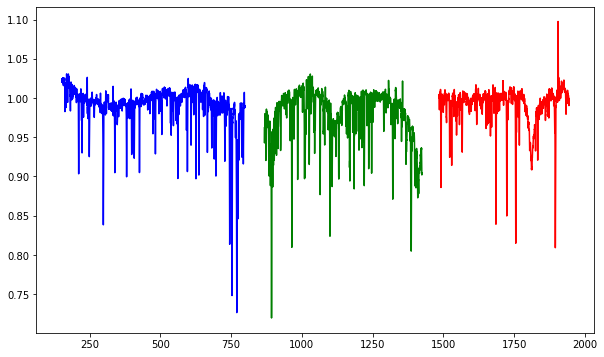

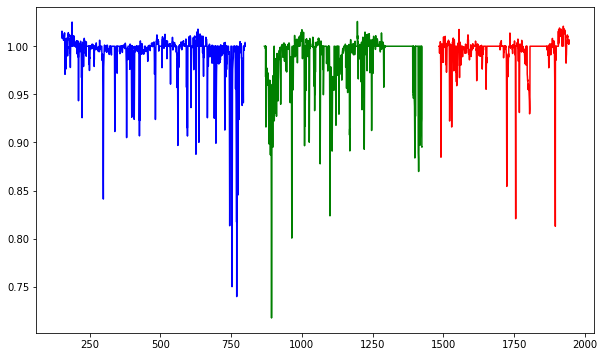


-------------------------------------------



1it [00:01,  1.36s/it]

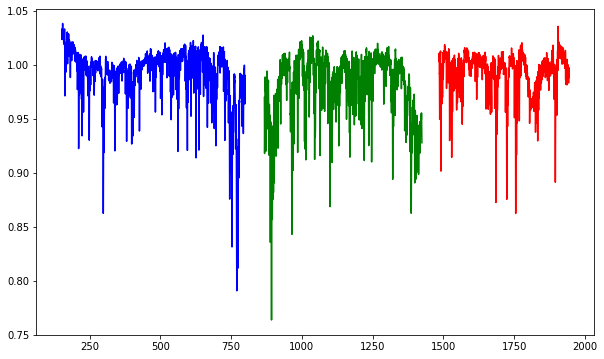

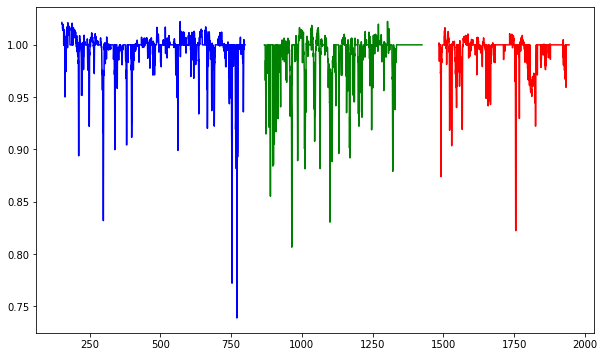


-------------------------------------------



2it [00:02,  1.35s/it]

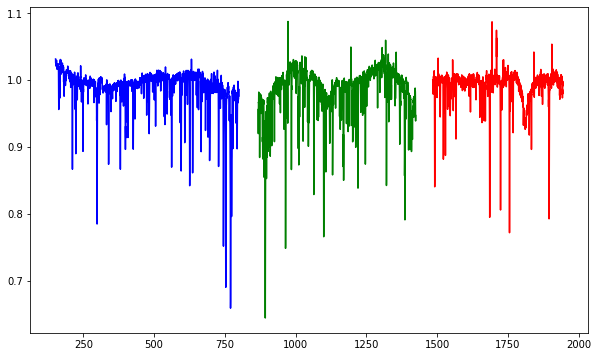

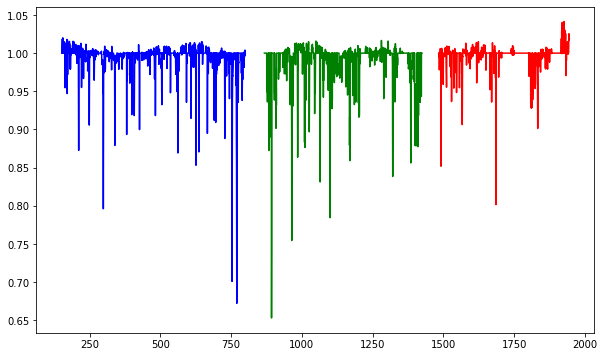


-------------------------------------------



3it [00:04,  1.49s/it]

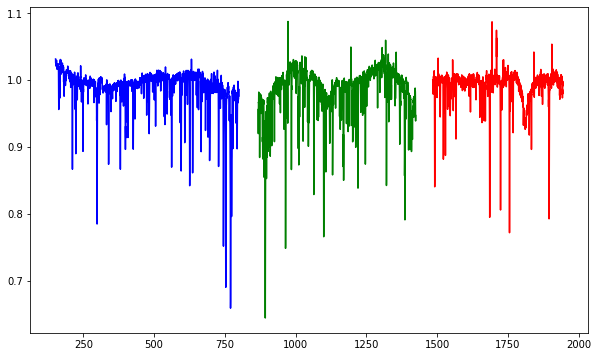

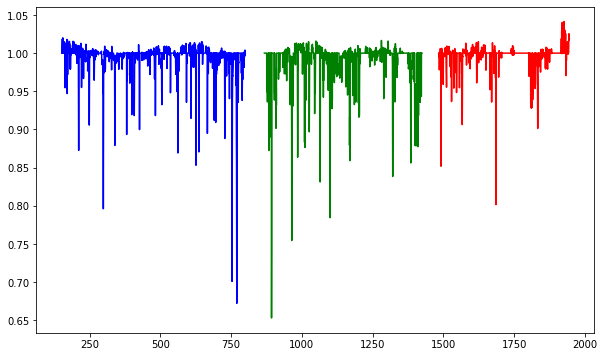


-------------------------------------------



4it [00:05,  1.44s/it]

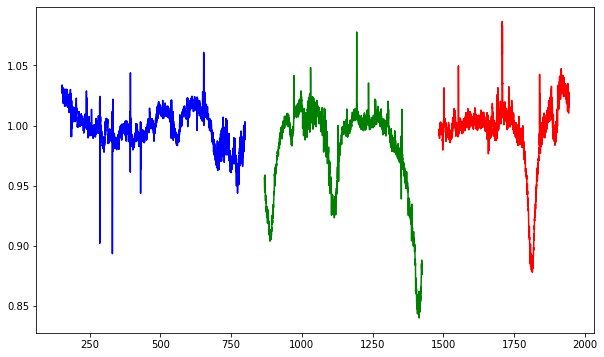

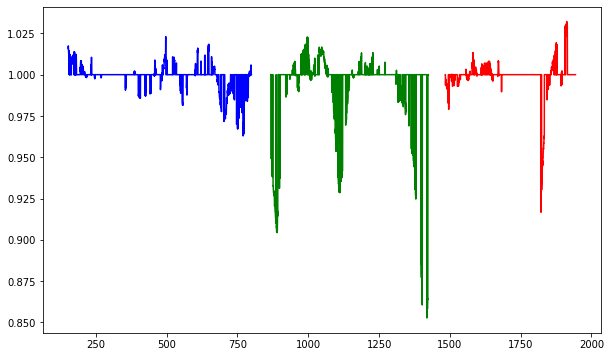


-------------------------------------------



5it [00:07,  1.40s/it]

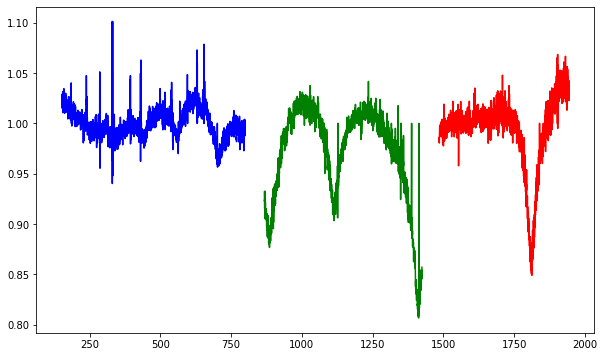

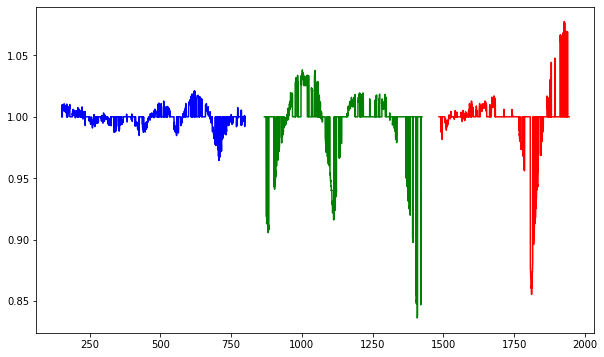


-------------------------------------------



6it [00:08,  1.38s/it]

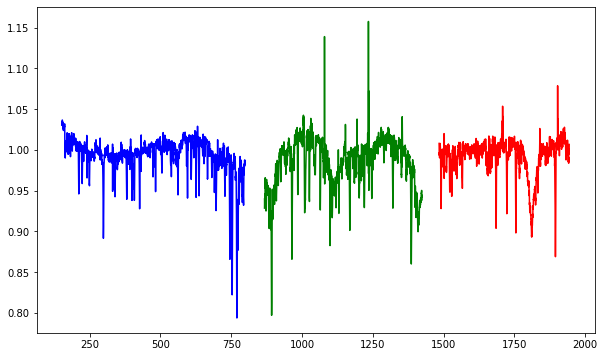

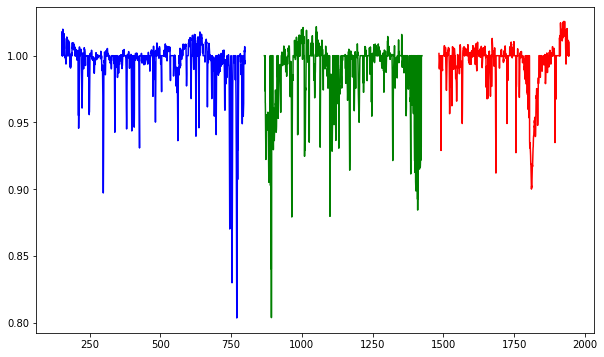


-------------------------------------------



7it [00:09,  1.37s/it]

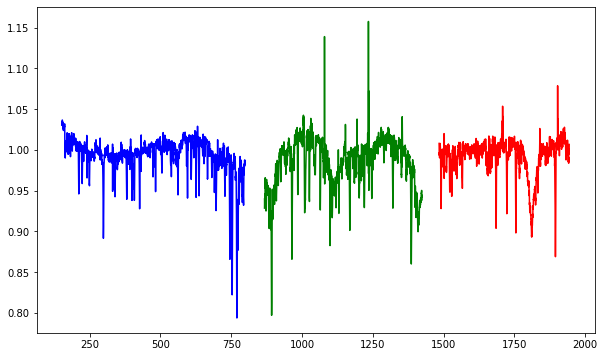

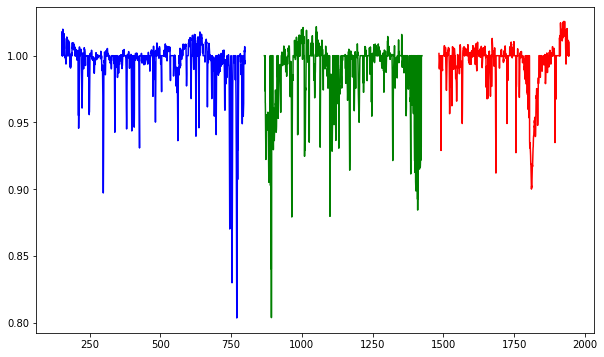


-------------------------------------------



8it [00:11,  1.36s/it]

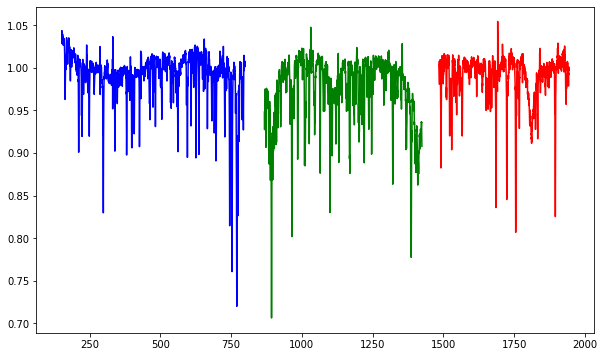

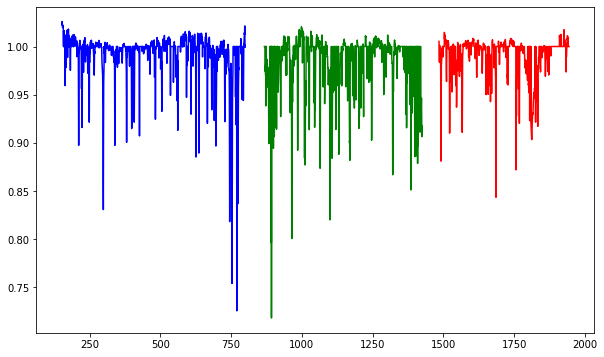


-------------------------------------------



9it [00:12,  1.36s/it]

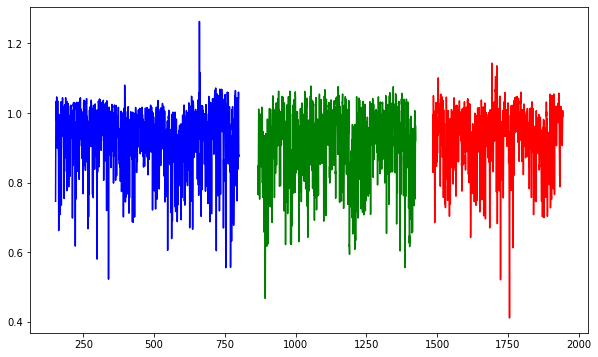

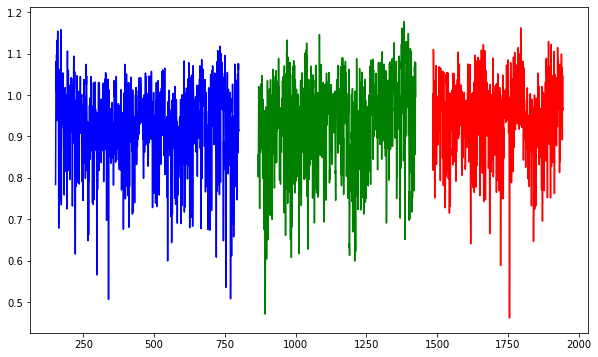


-------------------------------------------



10it [00:13,  1.36s/it]

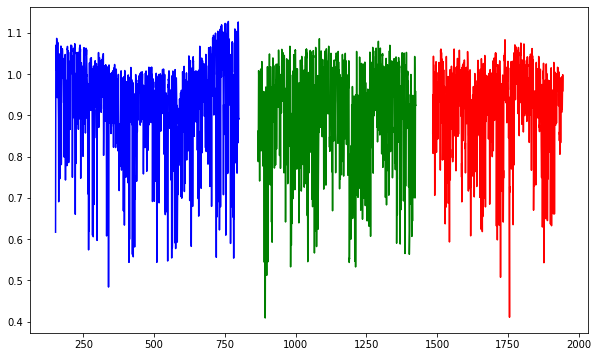

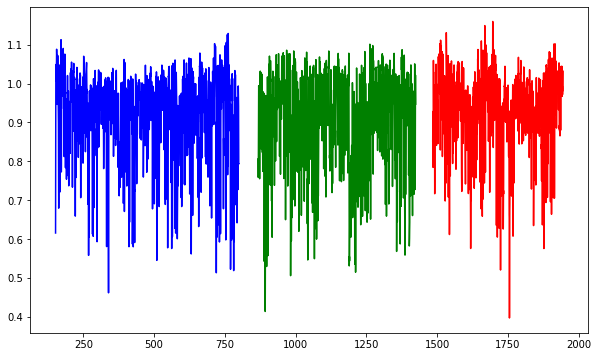


-------------------------------------------



11it [00:15,  1.36s/it]

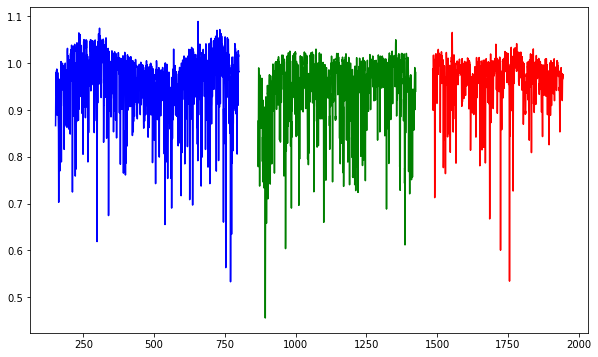

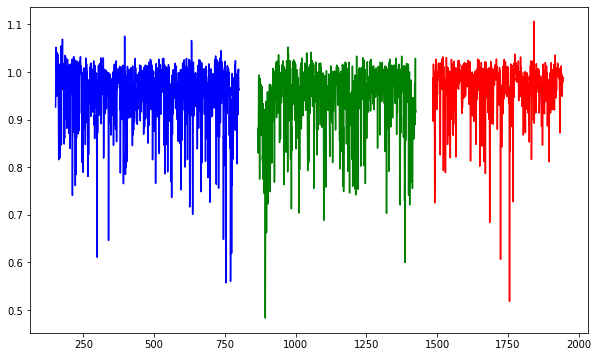


-------------------------------------------



12it [00:16,  1.36s/it]

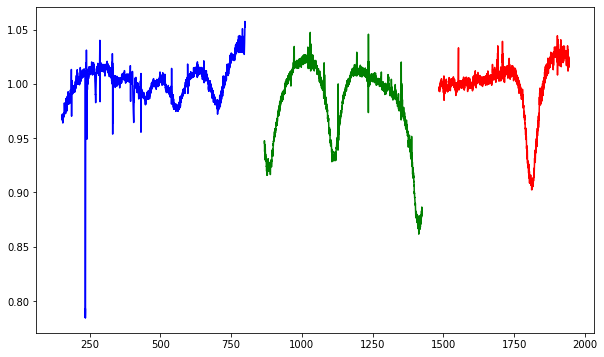

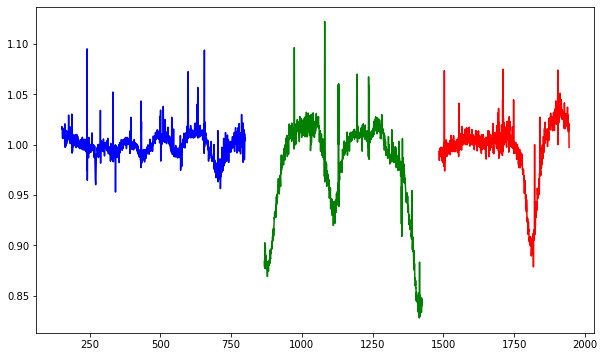


-------------------------------------------



13it [00:17,  1.35s/it]

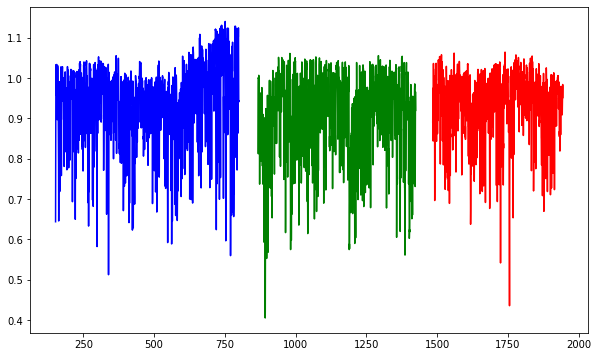

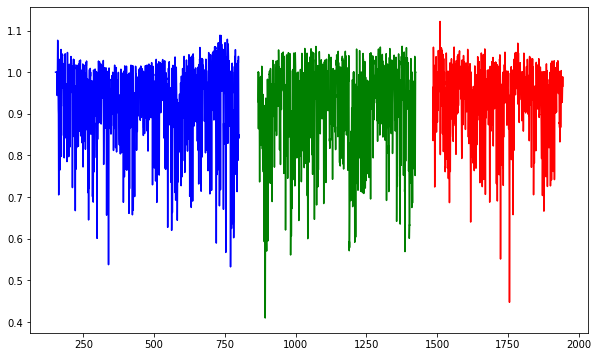


-------------------------------------------



14it [00:19,  1.37s/it]

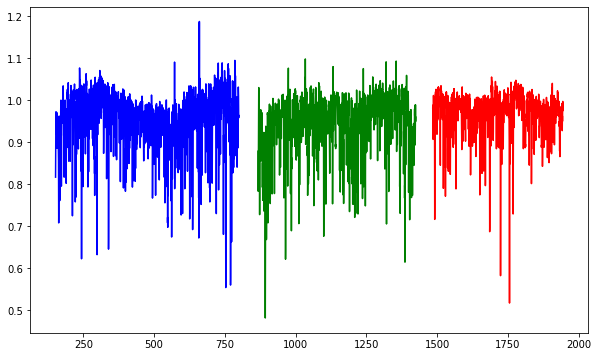

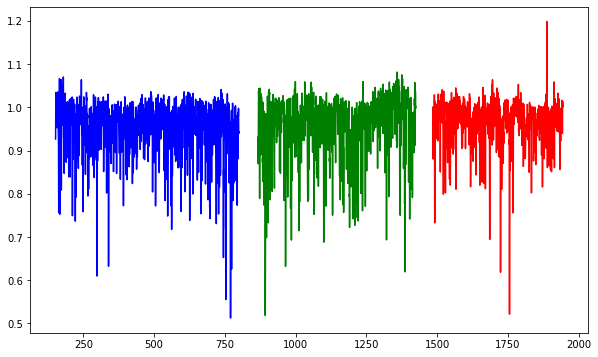


-------------------------------------------



15it [00:20,  1.37s/it]

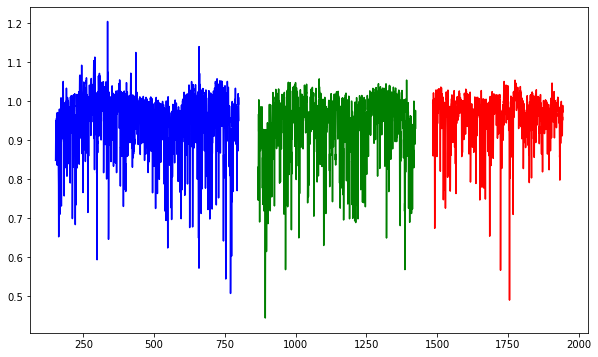

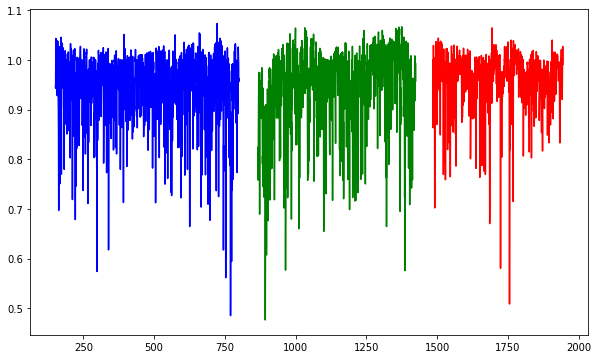


-------------------------------------------



16it [00:21,  1.37s/it]

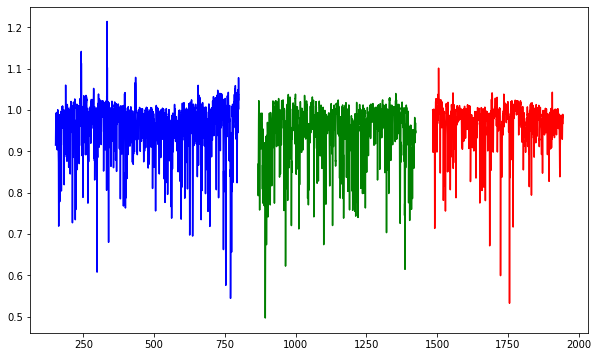

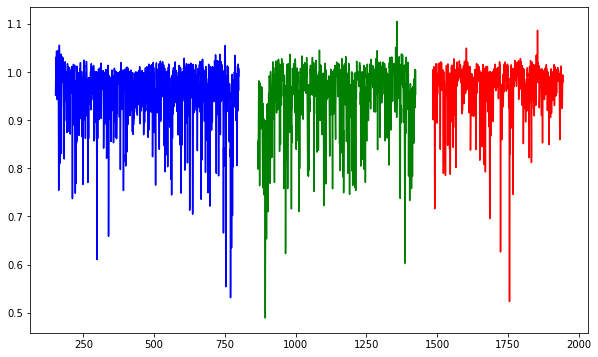


-------------------------------------------



17it [00:23,  1.37s/it]

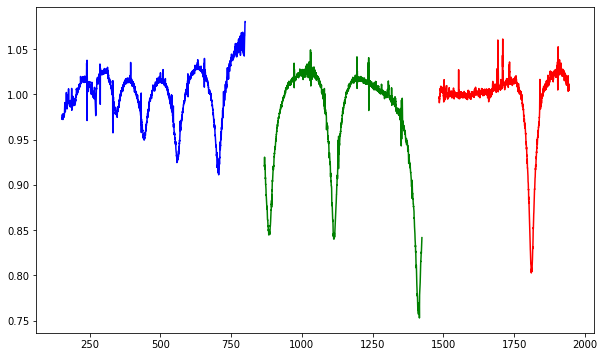

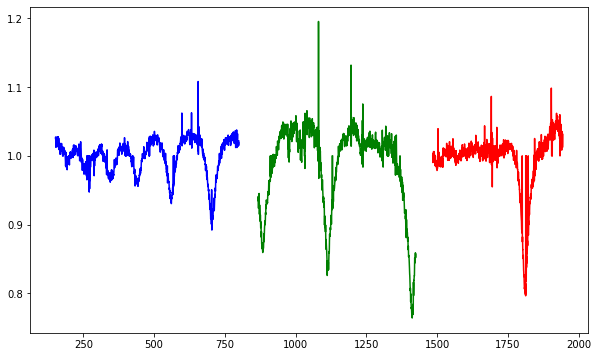


-------------------------------------------



18it [00:24,  1.36s/it]

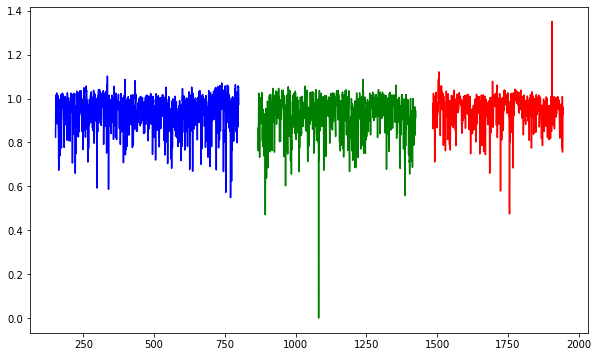

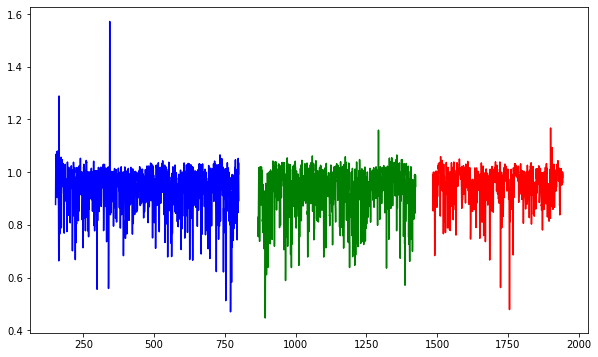


-------------------------------------------



19it [00:26,  1.36s/it]

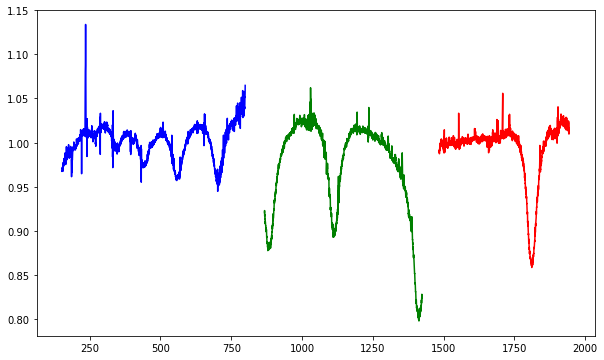

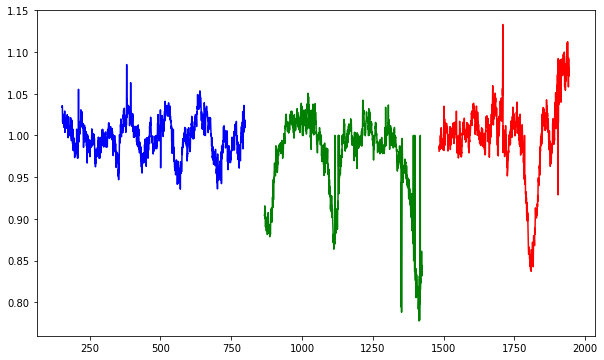


-------------------------------------------



20it [00:27,  1.36s/it]

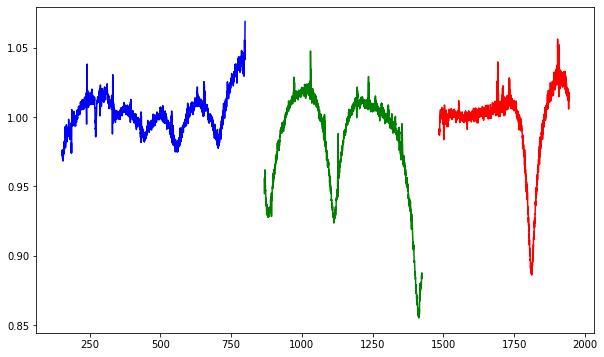

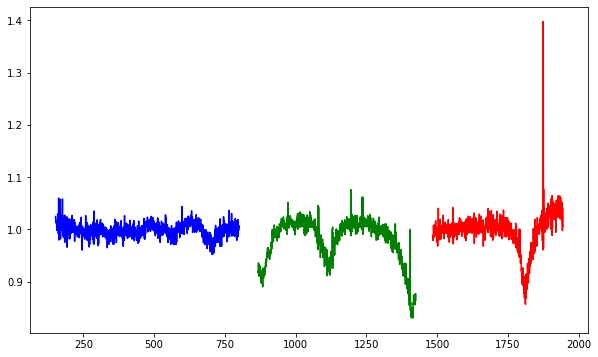


-------------------------------------------



21it [00:28,  1.34s/it]

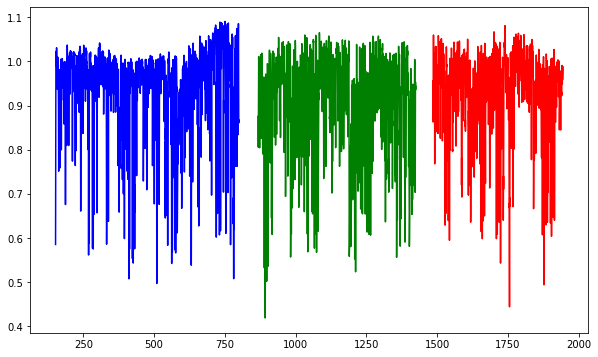

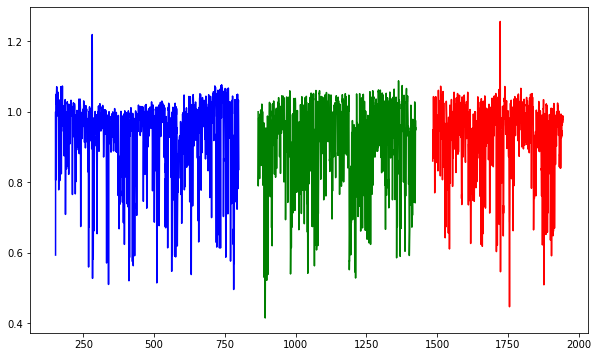


-------------------------------------------



22it [00:30,  1.35s/it]

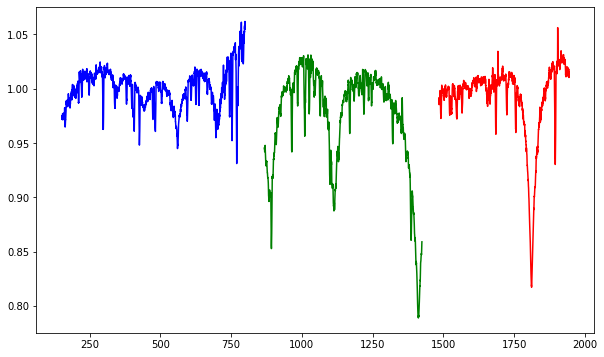

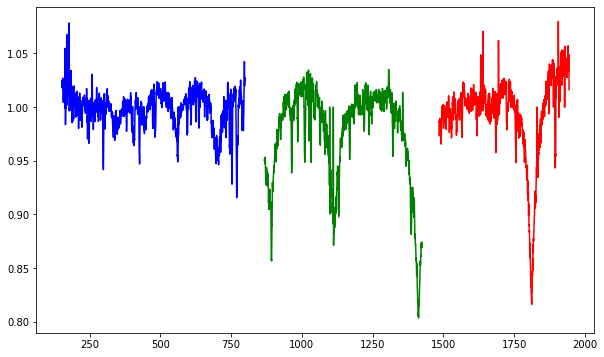


-------------------------------------------



23it [00:31,  1.34s/it]

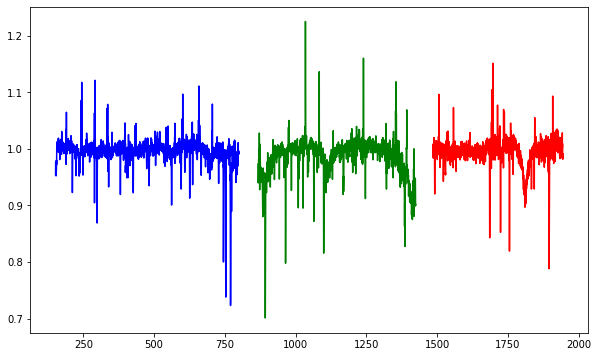

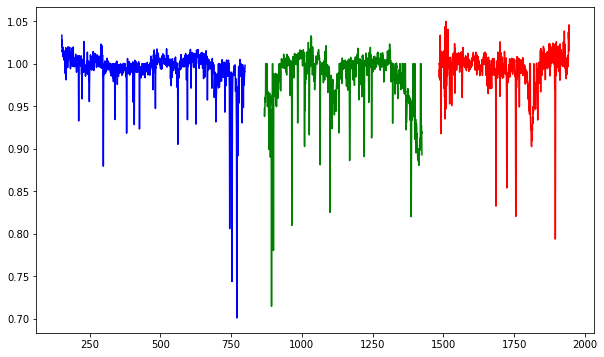


-------------------------------------------



24it [00:32,  1.35s/it]

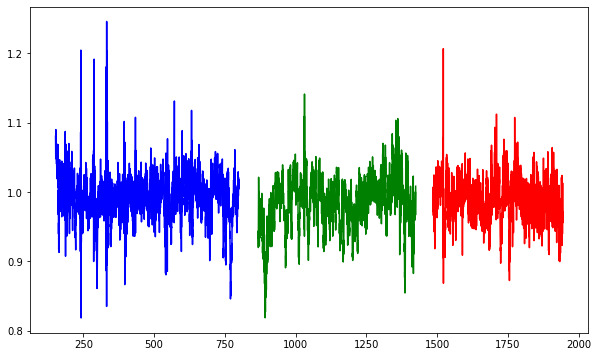

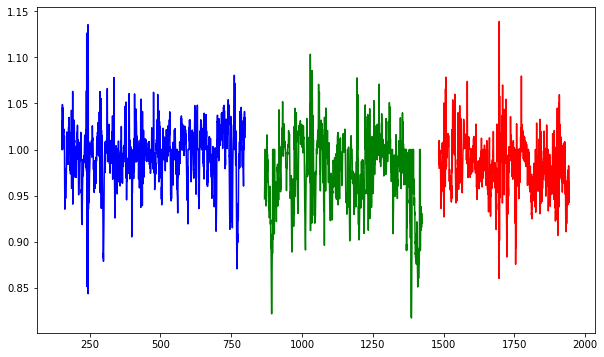


-------------------------------------------



25it [00:34,  1.35s/it]

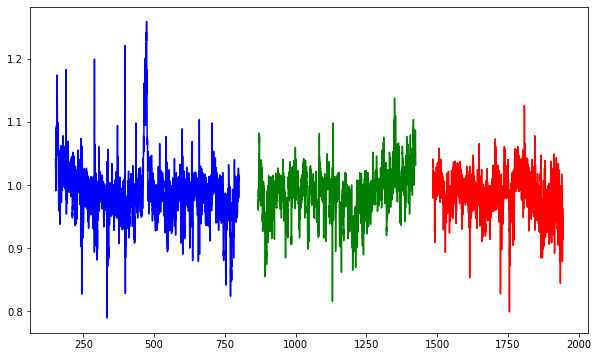

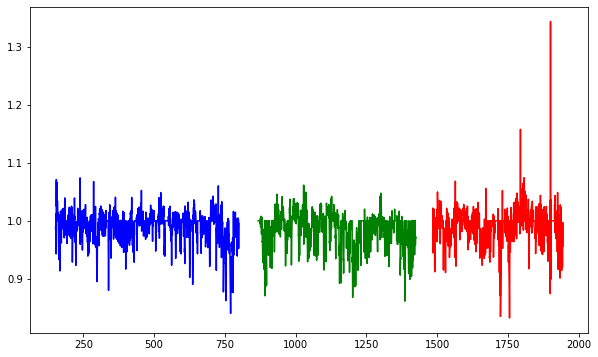


-------------------------------------------



26it [00:35,  1.35s/it]

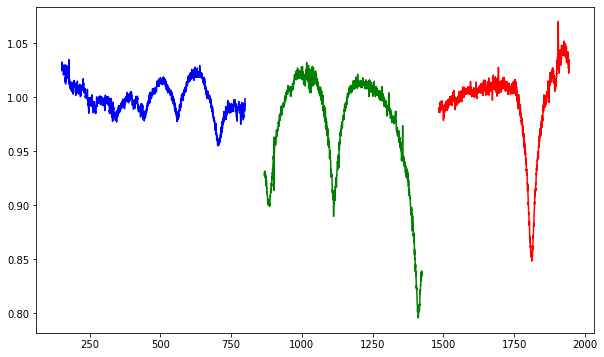

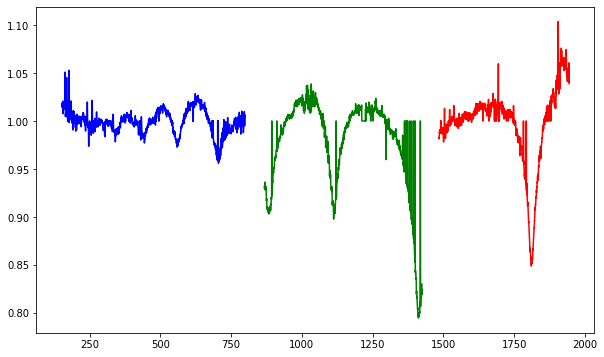


-------------------------------------------



27it [00:36,  1.35s/it]

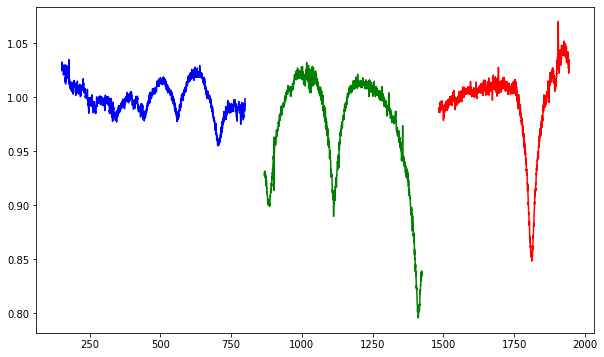

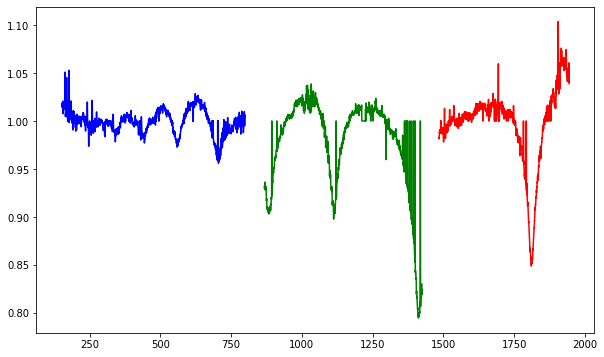


-------------------------------------------



28it [00:38,  1.35s/it]

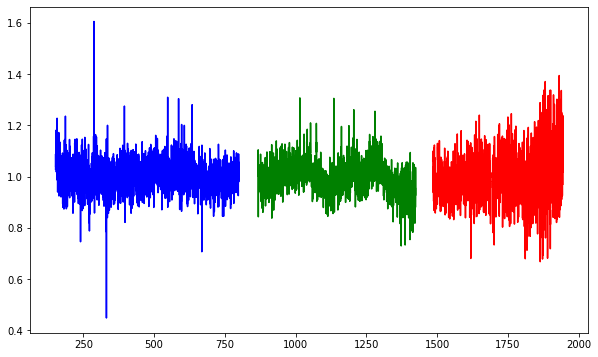

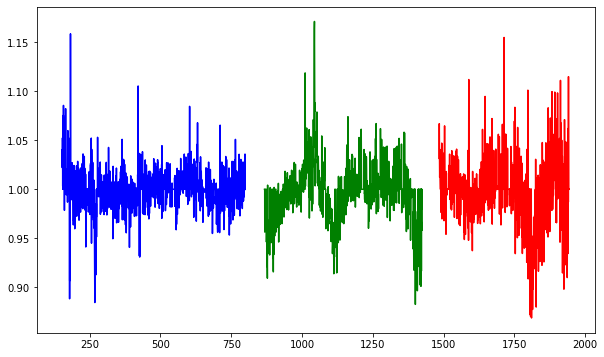


-------------------------------------------



29it [00:39,  1.35s/it]

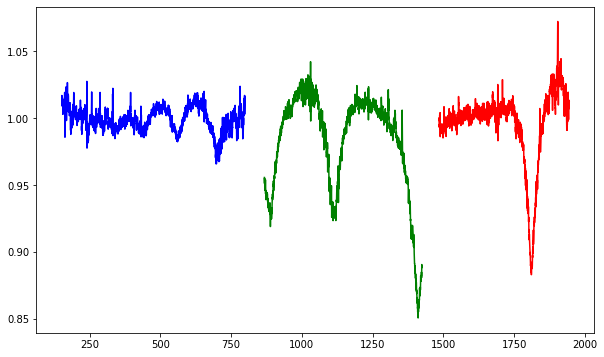

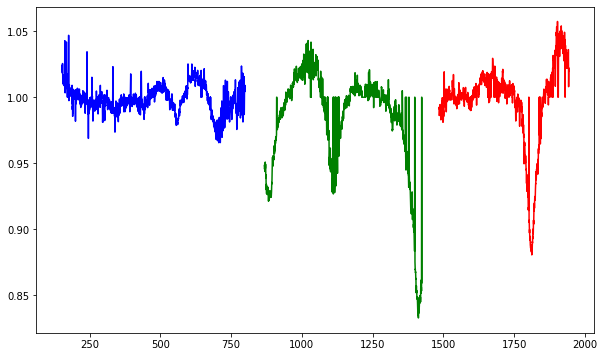


-------------------------------------------



30it [00:40,  1.34s/it]

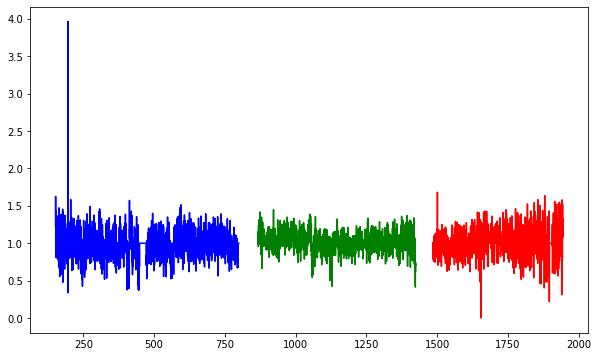

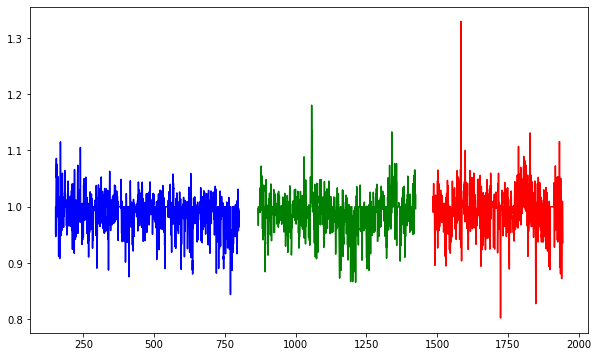


-------------------------------------------



31it [00:42,  1.35s/it]

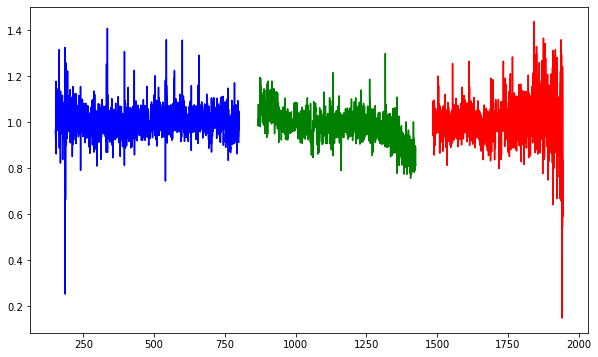

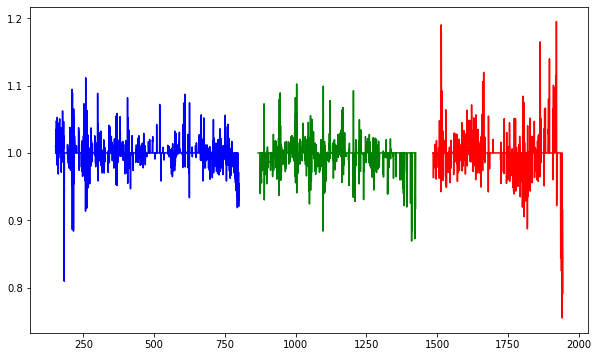


-------------------------------------------



32it [00:43,  1.35s/it]

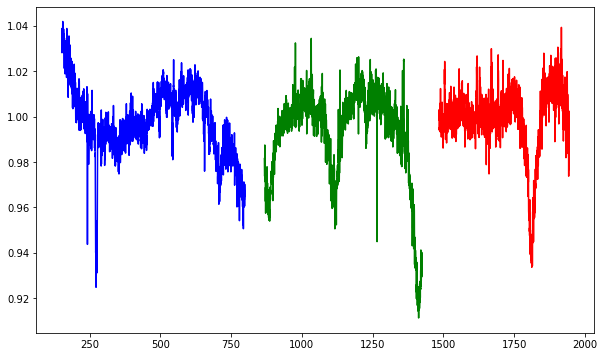

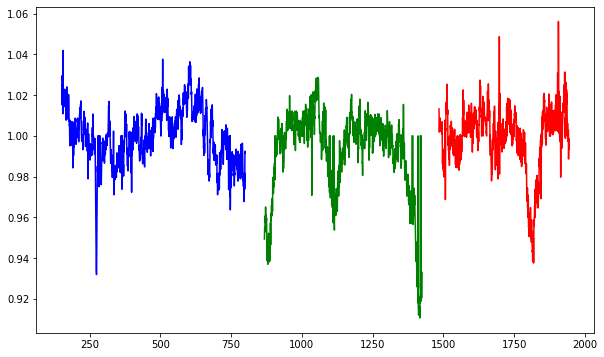


-------------------------------------------



33it [00:44,  1.35s/it]

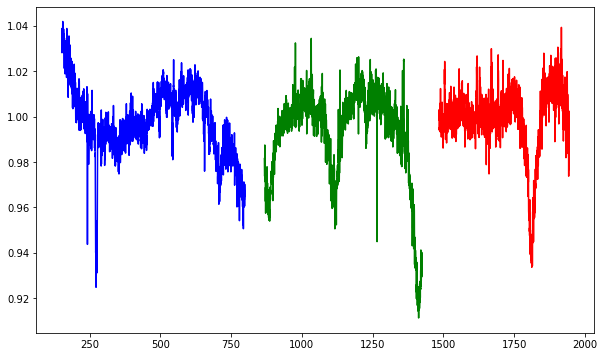

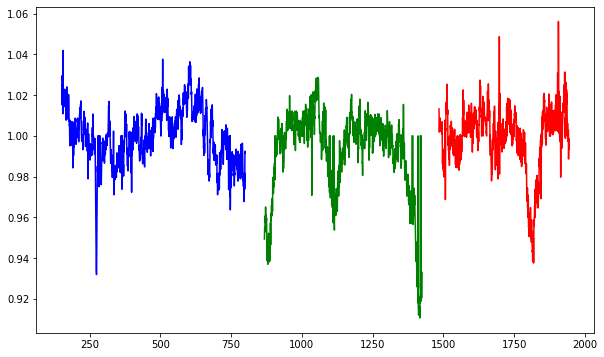


-------------------------------------------



34it [00:46,  1.36s/it]

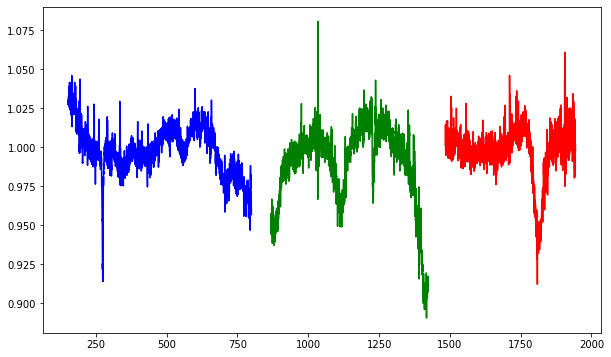

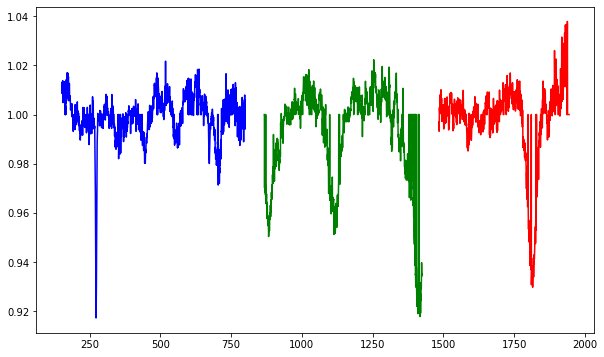


-------------------------------------------



35it [00:47,  1.36s/it]

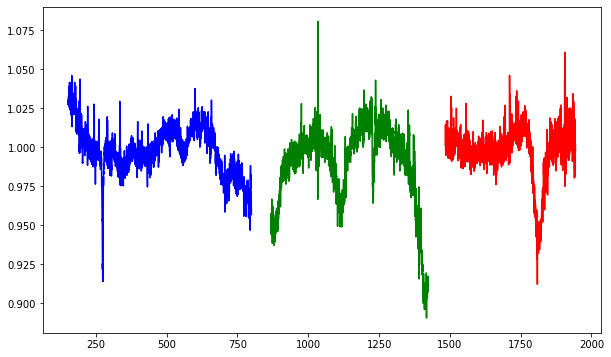

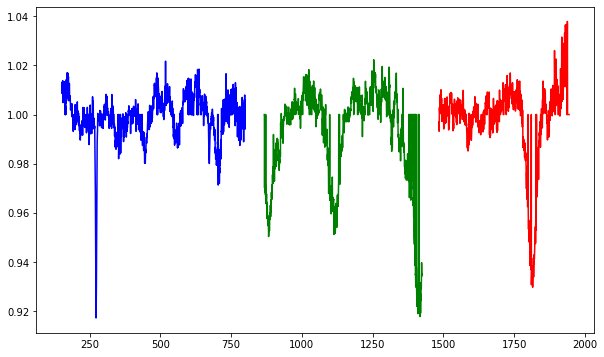


-------------------------------------------



36it [00:49,  1.36s/it]

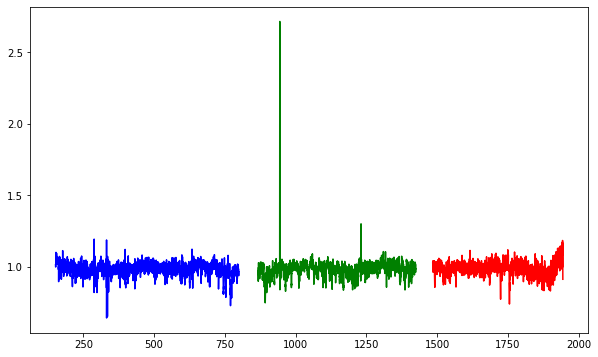

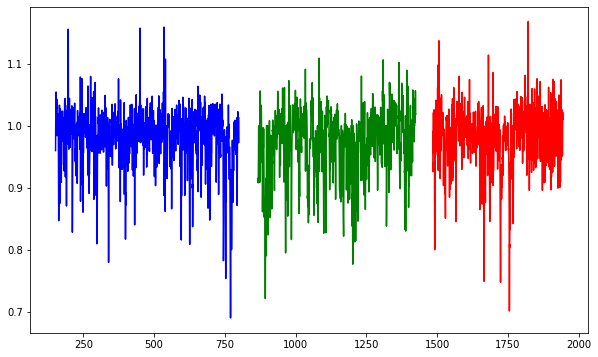


-------------------------------------------



37it [00:50,  1.36s/it]

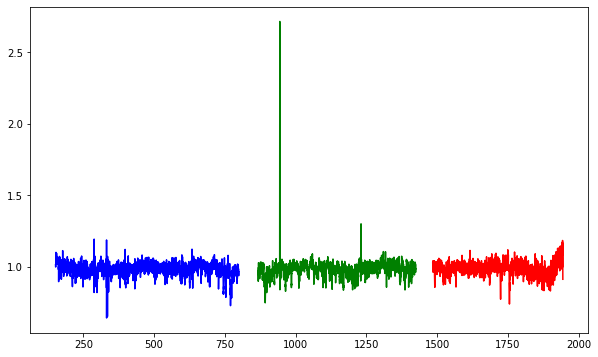

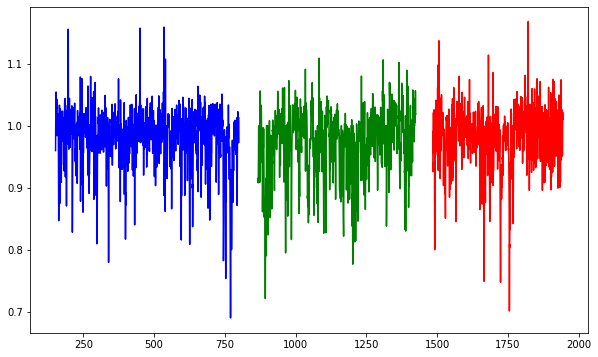


-------------------------------------------



38it [00:52,  1.47s/it]

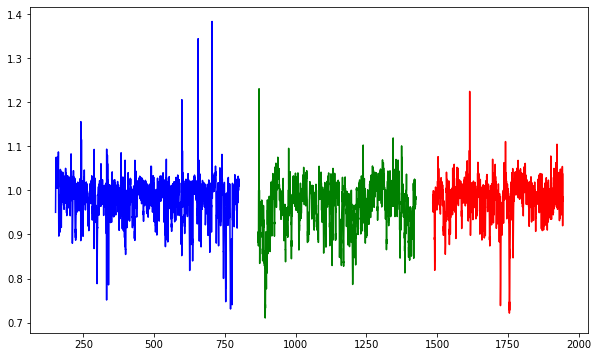

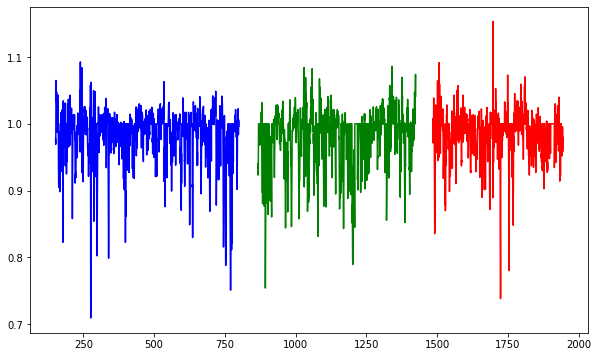


-------------------------------------------



39it [00:53,  1.44s/it]

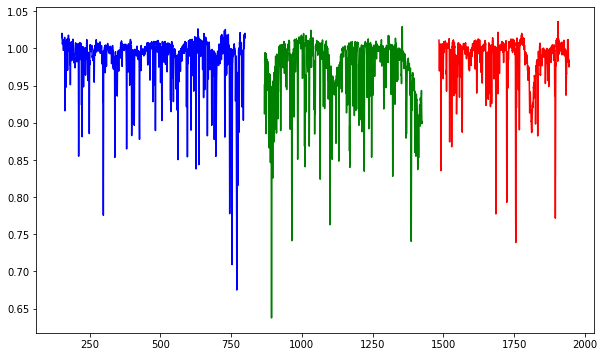

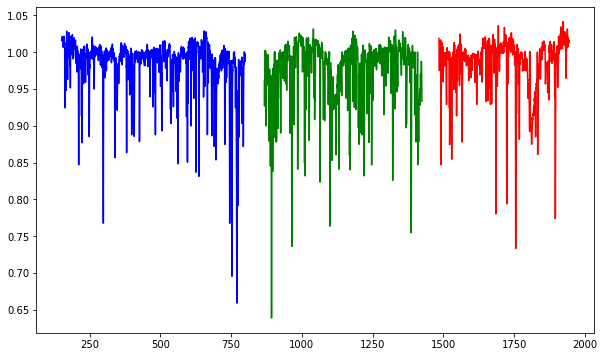


-------------------------------------------



39it [00:54,  1.39s/it]


KeyboardInterrupt: 

In [18]:
blue = wav[0]["Blue"]
red = wav[1]["Red"]
green = wav[2]["Green"]

for b, r, g in tqdm(zip(blue, red, green)):
    b_sdss_iv = list(b.values())[0]
    r_sdss_iv = list(r.values())[0]
    g_sdss_iv = list(g.values())[0]

    b_sdss_v = list(b.values())[1]
    r_sdss_v = list(r.values())[1]
    g_sdss_v = list(g.values())[1]

    b_l = list(b.values())[2]
    r_l = list(r.values())[2]
    g_l = list(g.values())[2]

    plotSpec(r_sdss_iv, g_sdss_iv, b_sdss_iv,
             r_l, g_l, b_l)

    plotSpec(r_sdss_v, g_sdss_v, b_sdss_v, 
             r_l, g_l, b_l)

    print("\n-------------------------------------------\n")

    time.sleep(1)
    
    

# Inference

In [21]:
model = load_folder(model_path)

cols = model.targetname
cols

/home/petershi/miniconda3/envs/SDSSV/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


Loaded astroNN model, model type: Bayesian Convolutional Neural Network -> ApogeeBCNNCensored


['teff',
 'logg',
 '[C/H]',
 '[CI/H]',
 '[N/H]',
 '[O/H]',
 '[Na/H]',
 '[Mg/H]',
 '[Al/H]',
 '[Si/H]',
 '[P/H]',
 '[S/H]',
 '[K/H]',
 '[Ca/H]',
 '[Ti/H]',
 '[TiII/H]',
 '[V/H]',
 '[Cr/H]',
 '[Mn/H]',
 '[Fe/H]',
 '[Co/H]',
 '[Ni/H]']

In [29]:
p = open("/geir_data/scr/petershi/serialized/predictions.pkl", "rb")

pred = pickle.load(p)

iv = pred["SDSS-IV"]
v = pred["SDSS-V"]

iv_df = pd.DataFrame(iv.values())
iv_df.columns = cols
iv_df

,teff,logg,[C/H],[CI/H],[N/H],[O/H],[Na/H],[Mg/H],[Al/H],[Si/H],...,[K/H],[Ca/H],[Ti/H],[TiII/H],[V/H],[Cr/H],[Mn/H],[Fe/H],[Co/H],[Ni/H]
0,5629.352539,3.195215,-0.409725,-0.376669,-0.849142,-0.519186,-0.488297,-0.520353,-0.761594,-0.499663,...,-0.504521,-0.529362,-0.647557,-0.393617,-0.693719,-0.686144,-0.791229,-0.653775,-0.639032,-0.655070
1,5463.008301,3.400984,-0.849782,-0.806883,-1.152411,-0.751450,-0.727300,-0.699376,-0.972124,-0.684986,...,-0.733777,-0.704669,-0.856152,-0.518332,-0.904626,-0.793981,-0.978630,-0.827441,-0.861119,-0.822622
2,5608.959473,3.559237,-0.374307,-0.295025,-0.562693,-0.494196,-0.456781,-0.419545,-0.541791,-0.418011,...,-0.450225,-0.417838,-0.524122,-0.335728,-0.635287,-0.548390,-0.593717,-0.516677,-0.570223,-0.520404
3,5404.130371,2.372514,-1.788445,-1.587743,-1.805145,-1.213412,-0.836226,-1.182820,-1.844753,-1.153434,...,-1.245746,-1.236765,-1.510644,-0.927498,-1.584649,-1.417320,-1.728185,-1.477915,-1.466883,-1.417629
4,5259.890625,2.199460,-2.028915,-1.761097,-1.602709,-1.257217,-0.744961,-1.208400,-1.797769,-1.174166,...,-1.275894,-1.243068,-1.529859,-0.930936,-1.659937,-1.411077,-1.707181,-1.471620,-1.502504,-1.432868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,4544.979492,3.351176,0.229131,0.164297,0.238818,0.274155,0.096520,0.254439,0.234353,0.200726,...,0.228551,0.224561,0.235081,-0.170472,0.127565,0.215882,0.263224,0.220287,0.138308,0.224819
885,4638.910645,2.421149,0.083544,0.067300,0.152492,0.105801,0.030235,0.178413,0.210452,0.089516,...,0.114557,0.034142,0.079286,0.175821,-0.048297,-0.037334,-0.104902,-0.025591,0.156465,0.031090
886,4939.317383,2.357029,-0.548013,-0.440108,-0.416398,-0.366401,-0.570212,-0.336851,-0.353730,-0.351853,...,-0.325961,-0.467504,-0.539694,-0.206197,-0.663701,-0.626505,-0.735783,-0.609388,-0.580322,-0.520964
887,4418.494629,2.154305,-0.096458,-0.100753,-0.069314,0.001054,-0.120288,0.058607,0.093391,-0.053217,...,-0.011087,-0.094151,-0.068062,0.031558,-0.248462,-0.200792,-0.323975,-0.184086,-0.011781,-0.120082


In [30]:
v_df = pd.DataFrame(v.values())
v_df.columns = cols
v_df

,teff,logg,[C/H],[CI/H],[N/H],[O/H],[Na/H],[Mg/H],[Al/H],[Si/H],...,[K/H],[Ca/H],[Ti/H],[TiII/H],[V/H],[Cr/H],[Mn/H],[Fe/H],[Co/H],[Ni/H]
0,5428.694336,3.312864,-0.823906,-0.761776,-1.110514,-0.800044,-0.852708,-0.769454,-0.967542,-0.742415,...,-0.731162,-0.787400,-0.945703,-0.622899,-1.053744,-0.967634,-1.142932,-0.972477,-0.998173,-0.947552
1,5512.025391,3.299596,-1.102911,-1.076286,-1.303589,-0.818958,-0.815170,-0.811365,-1.198858,-0.776870,...,-0.796775,-0.790060,-0.980900,-0.678266,-1.049130,-0.945860,-1.088714,-0.942501,-0.959722,-0.909694
2,5267.291992,3.143016,-0.984393,-1.202725,-1.704517,-0.992534,-1.006450,-0.878291,-1.534222,-0.931051,...,-0.911704,-0.941589,-1.121586,-0.602452,-1.212717,-1.123481,-1.355588,-1.132921,-1.190891,-1.070427
3,5072.593262,2.498526,-2.006998,-1.732008,-2.172523,-1.394892,-1.216070,-1.365453,-2.112229,-1.400946,...,-1.447322,-1.444778,-1.769840,-1.131271,-1.849113,-1.649573,-2.038317,-1.717025,-1.796499,-1.630066
4,5092.158691,2.210457,-1.978788,-1.863338,-1.853055,-1.510255,-1.300546,-1.521452,-2.220589,-1.462457,...,-1.506268,-1.512446,-1.856332,-1.225164,-1.958038,-1.685787,-2.069355,-1.777086,-1.892730,-1.645652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,4558.361816,3.319904,0.230398,0.092111,0.257262,0.182010,0.145124,0.254740,0.413966,0.204045,...,0.218537,0.229743,0.236638,-0.221986,0.189550,0.202157,0.260350,0.215707,0.196818,0.235487
885,4643.141113,2.437895,0.078569,0.007085,0.186972,0.093423,-0.113975,0.176769,0.198946,0.077294,...,0.087444,0.034424,0.063310,0.163086,-0.052302,-0.019582,-0.085862,-0.015214,0.126190,0.005081
886,4989.807617,2.384460,-0.499960,-0.533965,-0.371604,-0.453974,-0.570743,-0.344530,-0.375406,-0.350016,...,-0.356829,-0.457027,-0.552190,-0.183389,-0.697567,-0.649543,-0.744442,-0.607816,-0.469934,-0.516968
887,4422.899902,2.273369,-0.062955,-0.097283,-0.068136,-0.013429,-0.206112,0.026678,0.049927,-0.068189,...,-0.022871,-0.095399,-0.083419,0.062331,-0.229429,-0.222125,-0.349380,-0.204416,-0.050616,-0.117695


In [32]:
diff = iv_df - v_df
diff

,teff,logg,[C/H],[CI/H],[N/H],[O/H],[Na/H],[Mg/H],[Al/H],[Si/H],...,[K/H],[Ca/H],[Ti/H],[TiII/H],[V/H],[Cr/H],[Mn/H],[Fe/H],[Co/H],[Ni/H]
0,200.658203,-0.117648,0.414182,0.385107,0.261372,0.280857,0.364411,0.249101,0.205948,0.242751,...,0.226641,0.258039,0.298146,0.229283,0.360025,0.281490,0.351703,0.318702,0.359141,0.292482
1,-49.017090,0.101389,0.253129,0.269403,0.151178,0.067508,0.087870,0.111989,0.226734,0.091885,...,0.062997,0.085391,0.124747,0.159934,0.144505,0.151879,0.110084,0.115060,0.098603,0.087072
2,341.667480,0.416221,0.610086,0.907701,1.141824,0.498338,0.549669,0.458747,0.992430,0.513039,...,0.461480,0.523752,0.597465,0.266724,0.577430,0.575091,0.761871,0.616244,0.620669,0.550024
3,331.537109,-0.126012,0.218553,0.144265,0.367378,0.181480,0.379845,0.182633,0.267476,0.247512,...,0.201576,0.208013,0.259196,0.203773,0.264464,0.232253,0.310132,0.239110,0.329616,0.212437
4,167.731934,-0.010997,-0.050127,0.102241,0.250346,0.253038,0.555585,0.313052,0.422819,0.288291,...,0.230374,0.269378,0.326473,0.294228,0.298101,0.274710,0.362174,0.305466,0.390226,0.212784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,-13.382324,0.031272,-0.001267,0.072186,-0.018444,0.092145,-0.048604,-0.000301,-0.179614,-0.003318,...,0.010014,-0.005182,-0.001557,0.051514,-0.061985,0.013725,0.002874,0.004580,-0.058510,-0.010668
885,-4.230469,-0.016746,0.004975,0.060215,-0.034480,0.012378,0.144209,0.001645,0.011506,0.012222,...,0.027114,-0.000282,0.015976,0.012735,0.004005,-0.017752,-0.019040,-0.010376,0.030276,0.026009
886,-50.490234,-0.027431,-0.048052,0.093856,-0.044794,0.087573,0.000530,0.007679,0.021676,-0.001837,...,0.030868,-0.010477,0.012496,-0.022808,0.033865,0.023038,0.008659,-0.001572,-0.110388,-0.003996
887,-4.405273,-0.119064,-0.033503,-0.003470,-0.001177,0.014484,0.085823,0.031929,0.043464,0.014971,...,0.011784,0.001248,0.015357,-0.030773,-0.019034,0.021333,0.025405,0.020330,0.038835,-0.002387


In [49]:
mean = diff.loc[:, diff.columns != 'teff'].mean()

diff_cols = mean.index

five = mean - diff.loc[:, diff.columns != 'teff'].quantile(0.05)
ninetyfive = diff.loc[:, diff.columns != 'teff'].quantile(0.95) - mean


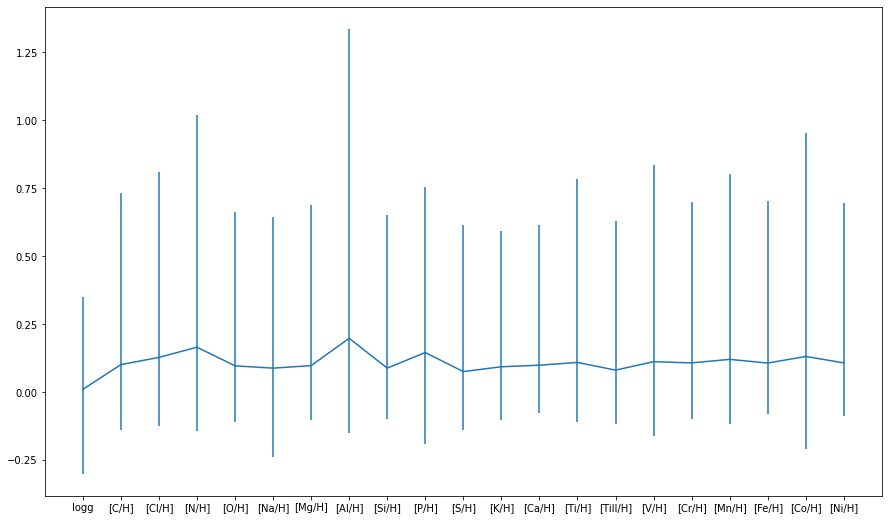

In [54]:
plt.figure(figsize=(15, 9))
plt.errorbar(x = diff_cols, y = mean, yerr = [five, ninetyfive])
plt.show()

In [59]:
print("mean is " +  str(diff["teff"].mean()))


yerr = [diff["teff"].quantile(0.05), diff["teff"].quantile(0.95)]

print("percentiles are " + str(yerr))

mean is -18.570633
percentiles are [-249.16806640624998, 162.52265624999973]
